# <h1 align="center">COSC2753 - Machine Learning</h1>

<h2 align="center">Task 2: Variety Classification</h2>

# TABLE OF CONTENT
[I. IMPORT NECESSARY LIBRARIES](#i-import-necessary-libraries)

[II. MODEL TRAINING: DISEASE CLASSIFICATION](#ii-model-training-disease-classification)

  - [1) Dataset Preprocessing](#1-data-preprocessing)

  - [2) Setup Global Variable](#2-setup-global-variables)

  - [3) Store Image in Generator](#3-store-image-in-generator)
  
  - [4) Baseline Models](#4-baseline-models)

  - [5) Model Selection and Tuning](#5-model-selection-and-tuning)


# I. IMPORT NECESSARY LIBRARIES

In [302]:
# Data manipulation libraries
import pandas as pd
import numpy as np
import importlib
import random
import os
import pickle

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Import custom libraries
import utils.visualizations as vi
import utils.preprocessing as pr
import utils.model_training as tr
import utils.model_training as mt

importlib.reload(vi)
importlib.reload(pr)
importlib.reload(tr)
importlib.reload(mt);

## Import Tensorflow for TensorFlow ≤ 2.12

In [111]:
# Deep learning libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.regularizers import l2
from tensorflow.keras import regularizers
# Transfer learning models
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras import models


## Using Keras for Keras 3.x with TensorFlow ≥ 2.13

In [16]:
# Deep learning libraries
import tensorflow as tf
from keras import Sequential, layers, models, Input
from keras.regularizers import l2
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.initializers import GlorotUniform

# Transfer learning models
from keras.applications import EfficientNetB0, ResNet50
from keras.models import load_model

# II. LOADING DATASET

In [4]:
df = pd.read_csv('./inputs/training_df.csv')
df

image_id                  label variety  age  \
0      100330.jpg  bacterial_leaf_blight   ADT45   45   
1      100365.jpg  bacterial_leaf_blight   ADT45   45   
2      100382.jpg  bacterial_leaf_blight   ADT45   45   
3      100632.jpg  bacterial_leaf_blight   ADT45   45   
4      101918.jpg  bacterial_leaf_blight   ADT45   45   
...           ...                    ...     ...  ...   
10402  107607.jpg                 tungro   Zonal   55   
10403  107811.jpg                 tungro   Zonal   55   
10404  108547.jpg                 tungro   Zonal   55   
10405  110245.jpg                 tungro   Zonal   55   
10406  110381.jpg                 tungro   Zonal   55   

                                              image_path  
0      ./inputs/train_images/bacterial_leaf_blight/10...  
1      ./inputs/train_images/bacterial_leaf_blight/10...  
2      ./inputs/train_images/bacterial_leaf_blight/10...  
3      ./inputs/train_images/bacterial_leaf_blight/10...  
4      ./inputs/train_images/bacterial_leaf_blight/10...  
...                                                  ...  
10402            ./inputs/train_images/tungro/107607.jpg  
10403            ./inputs/train_images/tungro/107811.jpg  
10404            ./inputs/train_images/tungro/108547.jpg  
10405            ./inputs/train_images/tungro/110245.jpg  
10406            ./inputs/train_images/tungro/110381.jpg  

[10407 rows x 5 columns]

# IV. MODEL TRAINING

To ensure that the results are stable for multiple run time, we setup the seed for dataset

In [5]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## 3) Task 2: Variety Classification

### 3.1) Helper Functions

### 3.2 Data Preprocessing 

#### 3.1) Split the dataset

Before applying any preprocessing technique, we must split the dataset into training and validation sets to avoid data leakage.

In [6]:
# Define random_state
random_state = 42

train_df, val_df = train_test_split(df, test_size=0.2, random_state=random_state)

vi.print_header("Train Dataset shape")
print("Number of Rows: ", train_df.shape[0])
print("Number of Columns: ", train_df.shape[1])

vi.print_header("Validation Dataset Shape")
print("Number of Rows: ", val_df.shape[0])
print("Number of Columns: ", val_df.shape[1])

+-----------------------------------------+
|           TRAIN DATASET SHAPE           |
+-----------------------------------------+
Number of Rows:  8325
Number of Columns:  5
+----------------------------------------------+
|           VALIDATION DATASET SHAPE           |
+----------------------------------------------+
Number of Rows:  2082
Number of Columns:  5


#### 3.2) Handle Imbalance Dataset

In the training dataset, the `variety` distribution is **extremely imbalanced**, with the `ADT45` accounting for over **65%** of the samples. This problem will cause significant bias if it is not handled properly.

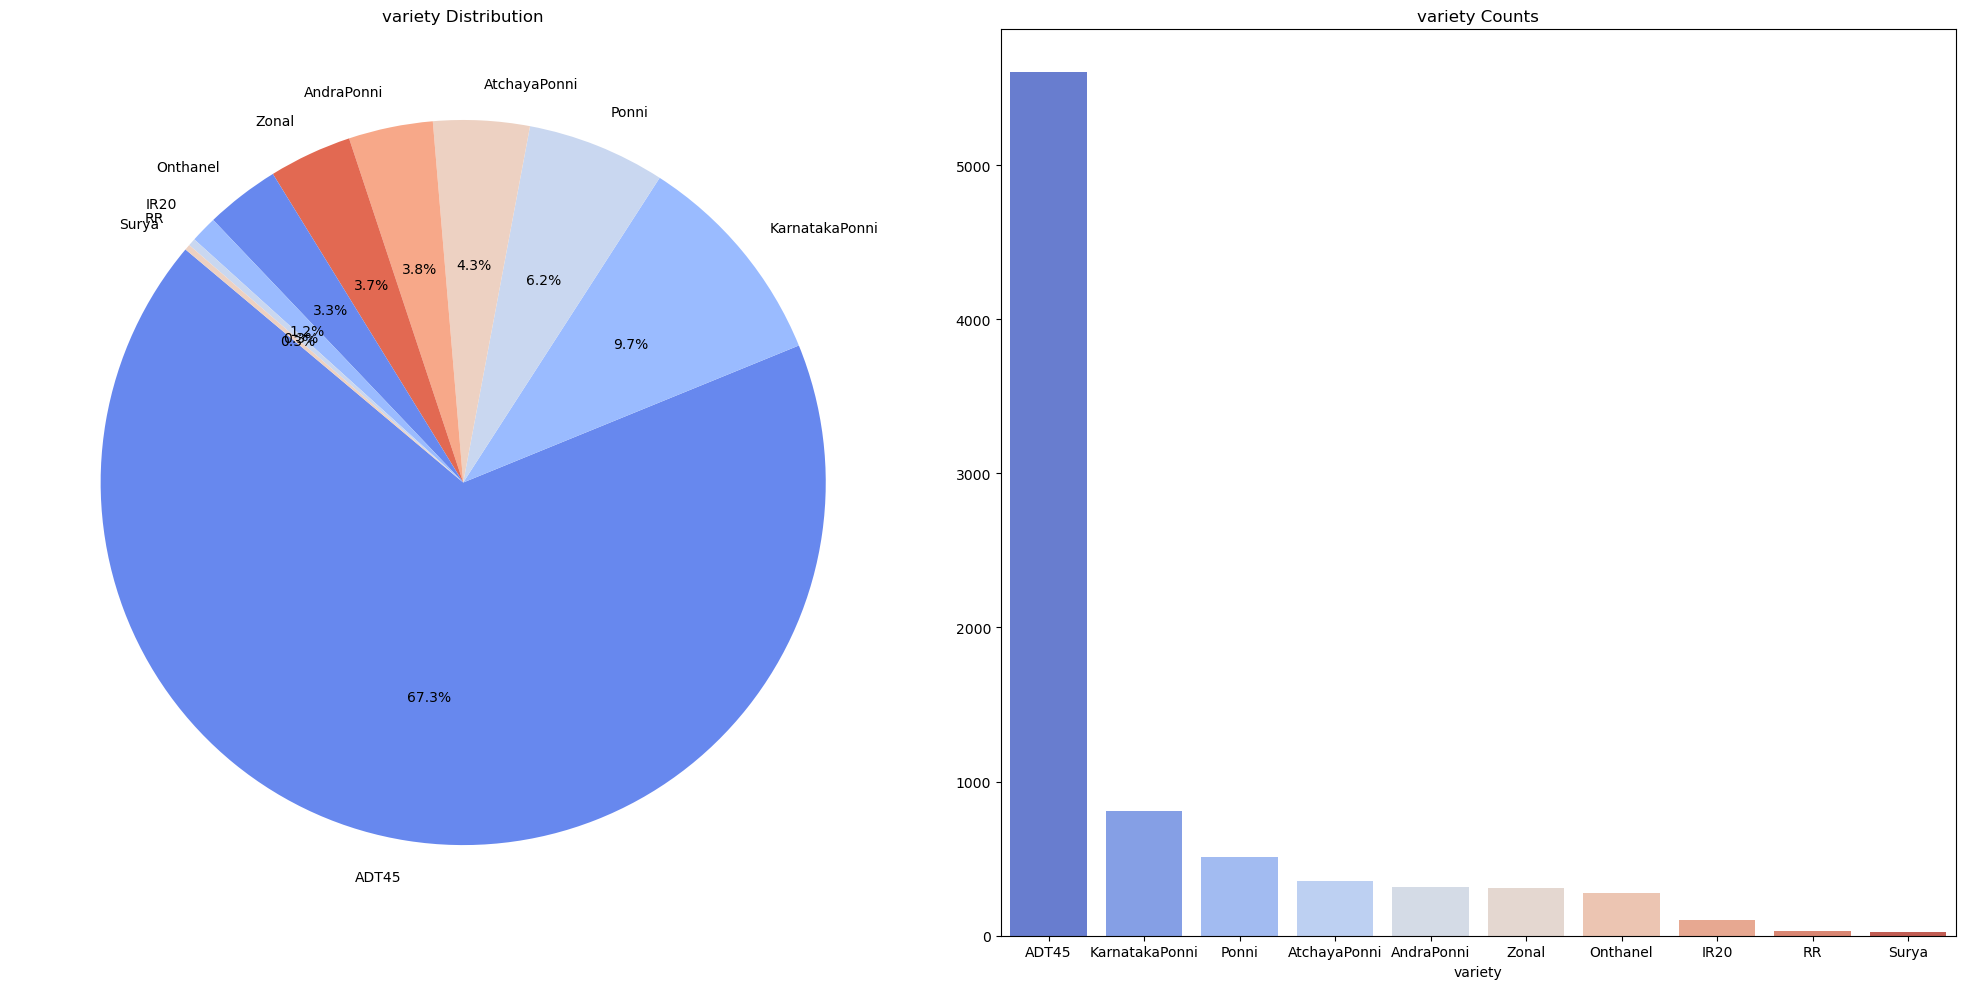

In [105]:
vi.visualize_category_distribution(train_df, "variety")

In [7]:
train_df["variety"].value_counts()

variety
ADT45             5601
KarnatakaPonni     809
Ponni              513
AtchayaPonni       357
AndraPonni         313
Zonal              308
Onthanel           276
IR20                99
RR                  28
Surya               21
Name: count, dtype: int64

#### 3.3) Handle Imbalance in `Variety` Distribution

The above pie chart provides us with the current distribution of the variety, where some varieties like ⁣`Surya`, `RR` , and `IR20` only account for under or equal to 1%, while certain varieties such as `ADT45` dominate the dataset.

To address this issue, we applied some **offline image augmentations** to increase the number of images for minority classes. The intensity of augmentation is based on the frequency tier of each variety. The logic is implemented in the `df_augmentation()` for a simple workflow.

| Tier                          | Variety Names                                     | Applied Augmentations                                                                             |
| ----------------------------- | ------------------------------------------------- | --------------------------------------------------------------------------------------------------|
| **Very Low (< 50 samples)**   | `Surya`, `RR`                                     | Rotation (±5°, ±10°, ±15°), Horizontal Flip, Vertical Flip, Brightness ±20%, Zoom-in Crop, Cutout |
| **Low (50–120 samples)**      | `IR20`                                            | Rotation (±5°, ±10°), Brightness ±20%                                                             |    
| **Mid-Low (120–400 samples)** | `Onthanel`, `AndraPonni`, `Zonal`, `AtchayaPonni` | Rotation (±5°), Random Crop                                                                       |
| **Mid (400–1000 samples)**     | `Ponni`, `KarnatakaPonni`                         | Rotation (±5°)                                                                                    |

With this approach we can diverse training sample for minority class. This preprocessing is expected to improve both accuracy and robustness in **Task 2 (Variety Classification)**


In [6]:
augmented_df, augmented_count = pr.df_augmentation(train_df)

Generating augmentations: 100%|██████████| 8325/8325 [00:13<00:00, 621.75it/s]

+------------------------------------------+
|           AUGMENTATION SUMMARY           |
+------------------------------------------+
Original dataset: 8325 images
Augmented dataset: 15913 images
Added 7588 augmented images


In [108]:
vi.print_header("Augmentation Summary for Varieties:")
for variety, count in sorted(augmented_count.items(), key=lambda x: x[1], reverse=True):
    original_count = train_df[train_df["variety"] == variety].shape[0]
    new_count = original_count + count
    print(f"- {variety}: +{count} new images (now {new_count} total)")

+---------------------------------------------------------+
|           AUGMENTATION SUMMARY FOR VARIETIES:           |
+---------------------------------------------------------+
- KarnatakaPonni: +1618 new images (now 2427 total)
- AtchayaPonni: +1071 new images (now 1428 total)
- Ponni: +1026 new images (now 1539 total)
- AndraPonni: +939 new images (now 1252 total)
- Zonal: +924 new images (now 1232 total)
- Onthanel: +828 new images (now 1104 total)
- IR20: +594 new images (now 693 total)
- RR: +336 new images (now 364 total)
- Surya: +252 new images (now 273 total)


In [10]:
train_augmented_df = pd.read_csv("inputs/meta_train_augmented.csv")

train_augmented_df

image_id                  label       variety  age  \
0                  109387.jpg                  blast  AtchayaPonni   50   
1                  109428.jpg  bacterial_leaf_blight         ADT45   72   
2                  105846.jpg             brown_spot         ADT45   55   
3                  104475.jpg                  blast         ADT45   70   
4                  102822.jpg  bacterial_leaf_streak         ADT45   68   
...                       ...                    ...           ...  ...   
15908        105389_rot_5.jpg             dead_heart      Onthanel   50   
15909  105389_crop_resize.jpg             dead_heart      Onthanel   50   
15910       108747_rot_-5.jpg                  hispa  AtchayaPonni   65   
15911        108747_rot_5.jpg                  hispa  AtchayaPonni   65   
15912  108747_crop_resize.jpg                  hispa  AtchayaPonni   65   

                                              image_path  
0                 ./inputs/train_images/blast/109387.jpg  
1      ./inputs/train_images/bacterial_leaf_blight/10...  
2            ./inputs/train_images/brown_spot/105846.jpg  
3                 ./inputs/train_images/blast/104475.jpg  
4      ./inputs/train_images/bacterial_leaf_streak/10...  
...                                                  ...  
15908  ./inputs/train_augmented_images/dead_heart/105...  
15909  ./inputs/train_augmented_images/dead_heart/105...  
15910  ./inputs/train_augmented_images/hispa/108747_r...  
15911  ./inputs/train_augmented_images/hispa/108747_r...  
15912  ./inputs/train_augmented_images/hispa/108747_c...  

[15913 rows x 5 columns]

+------------------------------------------------------------------------------------+
|           AUGMENTATION EXAMPLES FOR VERY LOW (<50) TIER - VARIETY: SURYA           |
+------------------------------------------------------------------------------------+


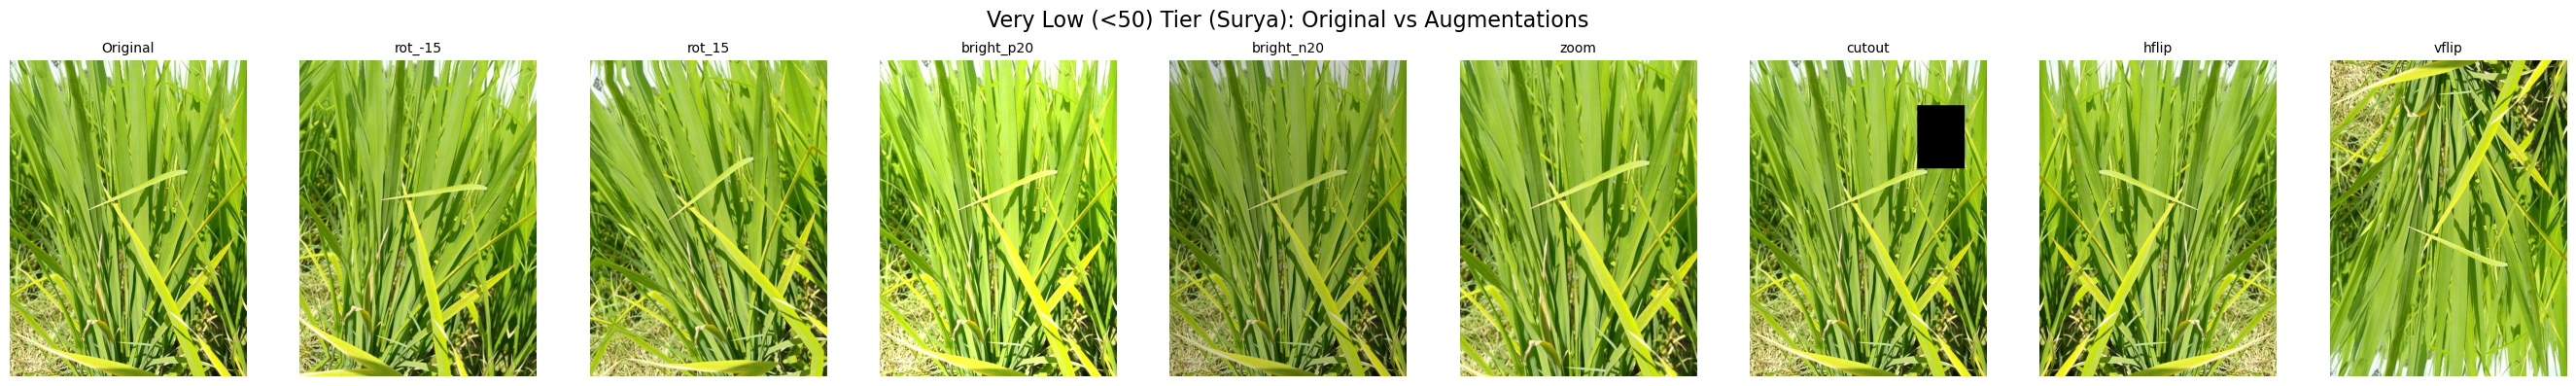

+---------------------------------------------------------------------------------+
|           AUGMENTATION EXAMPLES FOR LOW (50-120) TIER - VARIETY: IR20           |
+---------------------------------------------------------------------------------+


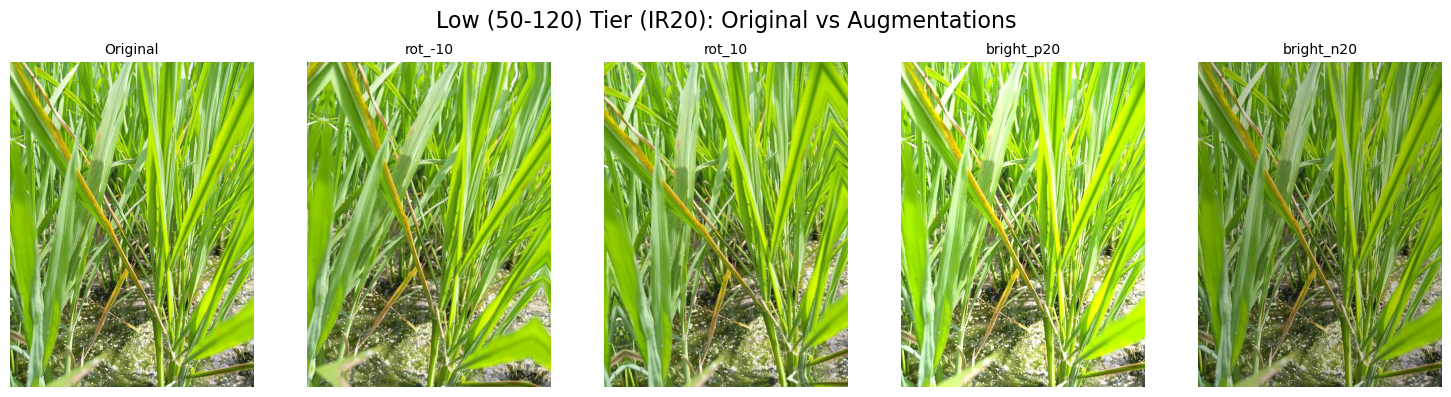

+------------------------------------------------------------------------------------------+
|           AUGMENTATION EXAMPLES FOR MID-LOW (120-400) TIER - VARIETY: ONTHANEL           |
+------------------------------------------------------------------------------------------+


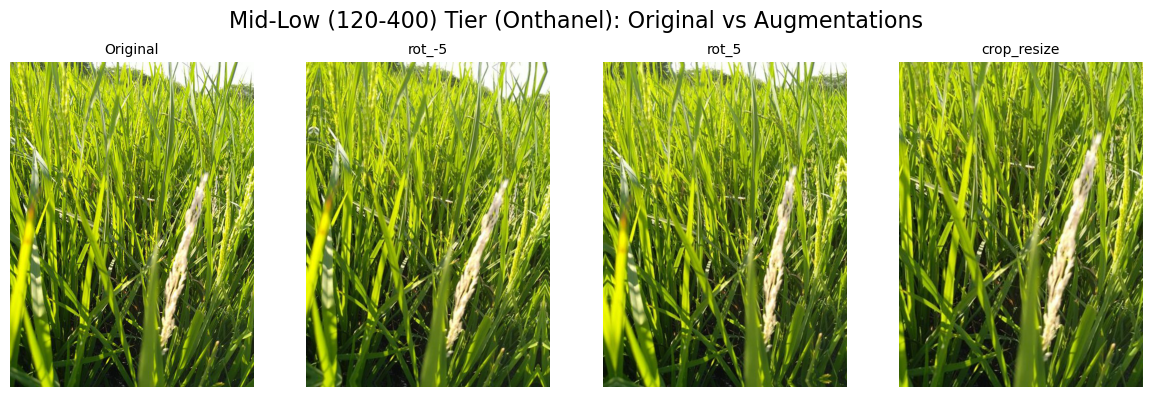

+------------------------------------------------------------------------------------+
|           AUGMENTATION EXAMPLES FOR MID (400-1000) TIER - VARIETY: PONNI           |
+------------------------------------------------------------------------------------+


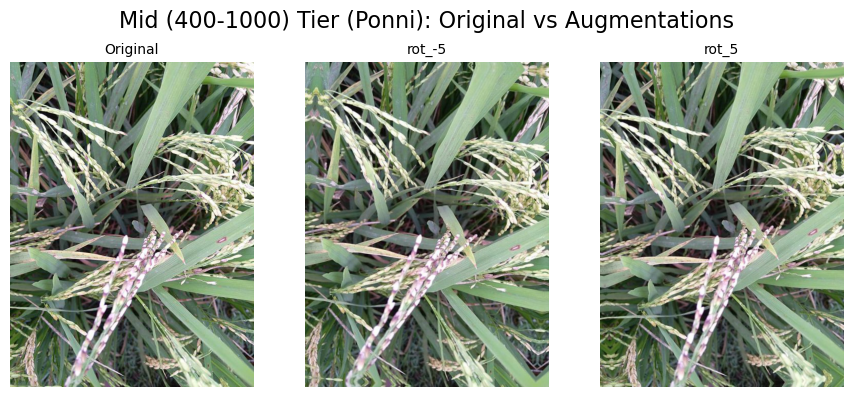

In [110]:
tiers = {
    "Very Low (<50)": ["Surya", "RR"],
    "Low (50-120)": ["IR20"],
    "Mid-Low (120-400)": ["Onthanel", "AndraPonni", "Zonal", "AtchayaPonni"],
    "Mid (400-1000)": ["Ponni", "KarnatakaPonni"],
}

augmentations = {
    "Very Low (<50)": [
        "rot_-15",
        "rot_15",
        "bright_p20",
        "bright_n20",
        "zoom",
        "cutout",
        "hflip",
        "vflip",
    ],
    "Low (50-120)": ["rot_-10", "rot_10", "bright_p20", "bright_n20"],
    "Mid-Low (120-400)": ["rot_-5", "rot_5", "crop_resize"],
    "Mid (400-1000)": ["rot_-5", "rot_5"],
}
vi.display_augmentation_examples(train_df, train_augmented_df, tiers, augmentations)

After applying offline augmentation to minority classes, the variety distribution become **more balanced**. The most dominant class `ADT45` has been reduced from **65%** to only around **35%**, while the percentages of minority classes such as `Surya`, `RR`, and `IR20` have increased their proportions. This adjustments will reduce model bias and enhance accuracy of variety classification in **Task 2**. 

However, the number of maximum variety is 5601 (`ADT45`), while the lowest variety `Surya` is only 273. It is still not enough for models to predict without bias in the domain class. To address the remaining imbalance, we apply **semi-supervised learning** to further expand the dataset.

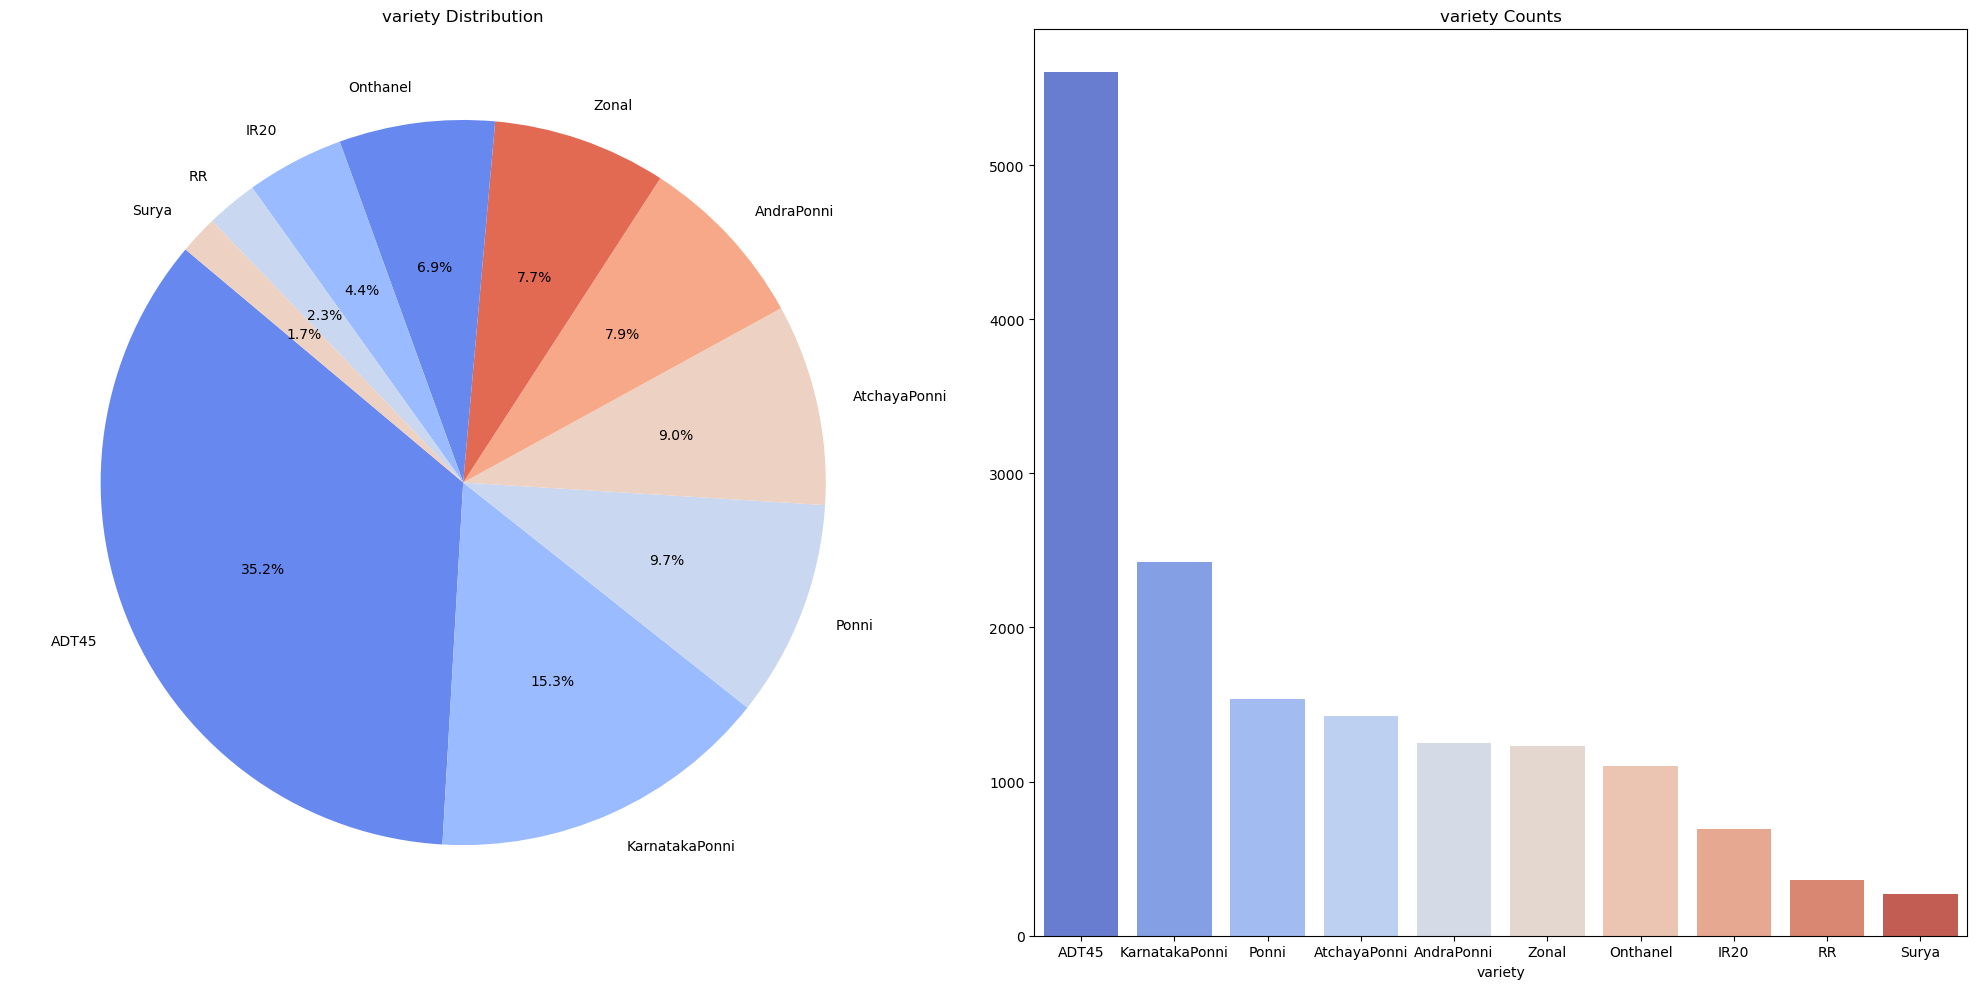

In [111]:
vi.visualize_category_distribution(train_augmented_df, "variety")

In [112]:
vi.print_header("The total number of each variety after augmenting")
train_augmented_df["variety"].value_counts()

+-----------------------------------------------------------------------+
|           THE TOTAL NUMBER OF EACH VARIETY AFTER AUGMENTING           |
+-----------------------------------------------------------------------+


variety
ADT45             5601
KarnatakaPonni    2427
Ponni             1539
AtchayaPonni      1428
AndraPonni        1252
Zonal             1232
Onthanel          1104
IR20               693
RR                 364
Surya              273
Name: count, dtype: int64

## 4) Semi-supervised Learning

We set the number of classes to 10 for the 10 varieties, set batch size to 32 and the Input_DIM as 64,64,3 for faster testing, in the final code we agreed to set the code to 128,128,3 for the image clarity

In [7]:
OUTPUT_CLASSES = 10
BATCH_SIZE = 32
INPUT_DIM = (64,64,3)

### 4.1) ImageDataGenerator and Data Augmentation for Training and Validation

This section outlines the process of preparing image data for training and validation using **ImageDataGenerator**.

Training Data Preparation:
1. **Convert 'variety' column to string**:  
   The target labels in the `train_augmented_df` dataframe are cast to the `str` type using:

2. **Create a copy of the dataframe**:  
   A copy of the `train_augmented_df` dataframe is created for data preparation:

In [11]:
train_augmented_df['variety'] = train_augmented_df['variety'].astype('str')

combine_variety_df = train_augmented_df.copy()

 **Setup ImageDataGenerator for Training**:  
   An `ImageDataGenerator` instance is created for augmenting and loading images during training:

 **Load Training Data**:  
   The `flow_from_dataframe` method is used to load images and labels for training, specifying the path to the images and their corresponding labels (`'variety'`). The images are resized to **64x64** pixels and grouped into batches:

In [21]:
train_datagen = ImageDataGenerator(data_format="channels_last")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=combine_variety_df,
    directory="",
    x_col="image_path",
    y_col="variety",
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    seed=42,
    shuffle=False,
)

Found 15913 validated image filenames belonging to 10 classes.


### 4.2) Validation Data Preparation:
1. **Convert 'variety' column to string for validation**:  
   The target labels in the `val_df` dataframe are also cast to the `str` type:

2. **Setup ImageDataGenerator for Validation**:  
   Another `ImageDataGenerator` instance is created for the validation data:
   ```python
   val_datagen = ImageDataGenerator(data_format='channels_last')
   ```

3. **Load Validation Data**:  
   Similarly to the training data, the validation data is loaded using `flow_from_dataframe`:

In [112]:
val_df['variety'] = val_df['variety'].astype('str')
val_datagen = ImageDataGenerator(data_format='channels_last')
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory= '',
    x_col='image_path',
    y_col='variety',
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42,
    shuffle = False
)

Found 2082 validated image filenames belonging to 10 classes.


### 4.3) model Sampling
add a simple CNN model for testing

In [117]:
model_variety = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model_variety.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [118]:
history = model_variety.fit(
    train_generator, validation_data=val_generator,
    epochs=25,
    verbose=1
)

Epoch 1/25
498/498 [==============================] - 228s 456ms/step - loss: 6.0553 - accuracy: 0.3222 - val_loss: 1.9578 - val_accuracy: 0.5346
Epoch 2/25
498/498 [==============================] - 102s 205ms/step - loss: 2.0075 - accuracy: 0.3569 - val_loss: 1.9297 - val_accuracy: 0.4573
Epoch 3/25
498/498 [==============================] - 92s 186ms/step - loss: 1.8119 - accuracy: 0.4060 - val_loss: 1.5484 - val_accuracy: 0.5562
Epoch 4/25
498/498 [==============================] - 93s 187ms/step - loss: 1.7106 - accuracy: 0.4387 - val_loss: 1.4877 - val_accuracy: 0.5773
Epoch 5/25
498/498 [==============================] - 92s 186ms/step - loss: 1.5524 - accuracy: 0.4902 - val_loss: 1.4275 - val_accuracy: 0.6705
Epoch 6/25
498/498 [==============================] - 104s 209ms/step - loss: 1.3834 - accuracy: 0.5332 - val_loss: 1.1848 - val_accuracy: 0.7041
Epoch 7/25
498/498 [==============================] - 95s 190ms/step - loss: 1.1903 - accuracy: 0.5891 - val_loss: 1.2136 - val


## 5) Setup Generator for Unlabeled Data and Pseudo-Labeling

### 5.1) Setup Generator for Unlabeled Data

To work with unlabeled data, we first set up a generator using `ImageDataGenerator`. This is used to load images without labels and prepare them for pseudo-labeling

In [119]:
# unlabel data 
unlabeled_datagen = ImageDataGenerator(data_format='channels_last')

# Create a generator for unlabeled data
unlabeled_generator = unlabeled_datagen.flow_from_directory(
    directory='inputs/unlabel', 
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=None,  
    shuffle=False
)


Found 9558 images belonging to 6 classes.


### 5.2) Generate Pseudo-Labels for Unlabeled Data

After preparing the generator, we generate pseudo-labels for the unlabeled data by predicting the labels using the trained model.

1. **Make Predictions on Unlabeled Data**: Use the trained model to predict the classes of the unlabeled data.

2. **Filter High-Confidence Predictions**: Only predictions with a confidence score above a certain threshold (e.g., 0.9) are considered.


3. **Map Class Indices to Class Names**: Convert the predicted class indices to their corresponding class names using the class indices from the training generator.

In [120]:
print("\nGenerating pseudo-labels for unlabeled data...")

predictions = model_variety.predict(unlabeled_generator)
predicted_classes = np.argmax(predictions, axis=1)
confidence_scores = np.max(predictions, axis=1)


confidence_threshold = 0.9
high_confidence_mask = confidence_scores > confidence_threshold

class_indices = train_generator.class_indices 
inv_class_indices = {v: k for k, v in class_indices.items()}
predicted_varieties = [inv_class_indices[idx] for idx in predicted_classes]


image_paths = np.array(unlabeled_generator.filenames)
image_ids = [os.path.basename(path) for path in image_paths]

high_confidence_df = pd.DataFrame({
    'image_id': np.array(image_ids)[high_confidence_mask],
    'label': '',  
    'variety': np.array(predicted_varieties)[high_confidence_mask],
    'age': '',    
    'image_path': image_paths[high_confidence_mask]
})


Generating pseudo-labels for unlabeled data...
299/299 [==============================] - 135s 453ms/step


### 5.3) Iterative Pseudo-Labeling and Model Training

#### 5.3.1) Initialize DataFrames for Iteration
```python
original_combine_df = train_augmented_df.copy()
added_pseudo_df = pd.DataFrame(columns=original_combine_df.columns)
```
- **`original_combine_df`**: The original labeled training dataset.
- **`added_pseudo_df`**: A DataFrame to store the pseudo-labeled data.

#### 5.3.2) Define Selected Varieties and Confidence Threshold
```python
selected_varieties = ['RR', 'Surya', 'IR20']
confidence_threshold = 0.9
```
- **`selected_varieties`**: The varieties to be selected for pseudo-labeling.
- **`confidence_threshold`**: Only predictions with confidence higher than **0.9** will be considered.

In [12]:
original_combine_df = train_augmented_df.copy()
added_pseudo_df = pd.DataFrame(columns=original_combine_df.columns)

selected_varieties = ['RR', 'Surya', 'IR20']
confidence_threshold = 0.9

### 5.4) Iterative Process (Repeated for 6 Iterations)

 **Iteration Steps:**
- **Reset Data**: Combine original labeled data with pseudo-labeled data added so far.

- **Update Generator**: Update the training generator with the new combined data.

- **Train Model**: Train the model for 1 epoch on the updated dataset.


- **Make Predictions on Unlabeled Data**: Predict labels for the unlabeled data.


- **Map Class Indices to Class Names**: Convert predicted class indices back to their respective variety names.

- **Prepare DataFrame for High-Confidence Predictions**: Filter out predictions with low confidence and prepare the DataFrame.


- **Filter for Selected Varieties**: Only include predictions for the selected varieties.

- **Remove Already-Added Data**: Ensure that previously added pseudo-labeled data is not added again.


- **Add to Pseudo-Label Data**: Append the new high-confidence samples to `added_pseudo_df`.

In [ ]:
for iteration in range(6):
    print(f"\n=== Iteration {iteration+1} ===")
    
  
    combine_df = pd.concat([original_combine_df, added_pseudo_df], ignore_index=True)
    
  
    train_generator_iter = train_datagen.flow_from_dataframe(
        dataframe=combine_df,
        directory='',
        x_col='image_path',
        y_col='variety',
        target_size=(64, 64),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        seed=42,
        shuffle=False
    )
    
    # 3. Train the model
    model_variety.fit(
        train_generator_iter,
        validation_data=val_generator,
        epochs=1,  
        verbose=1
    )
    
    # 4. Predict on unlabeled data
    predictions = model_variety.predict(unlabeled_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    confidence_scores = np.max(predictions, axis=1)
    
    # 5. Map class indices to variety names
    class_indices = train_generator_iter.class_indices
    inv_class_indices = {v: k for k, v in class_indices.items()}
    predicted_varieties = [inv_class_indices[idx] for idx in predicted_classes]
    
    # 6. Prepare DataFrame for high-confidence predictions
    image_paths = np.array(unlabeled_generator.filepaths)
    image_ids = [os.path.basename(path) for path in image_paths]
    
    high_confidence_mask = confidence_scores > confidence_threshold
    high_confidence_df = pd.DataFrame({
        'image_id': np.array(image_ids)[high_confidence_mask],
        'label': '',  # Unknown for unlabeled data
        'variety': np.array(predicted_varieties)[high_confidence_mask],
        'age': '',    # Unknown for unlabeled data
        'image_path': image_paths[high_confidence_mask]
    })
    

    filtered_df = high_confidence_df[high_confidence_df['variety'].isin(selected_varieties)]
    

    already_added_ids = set(added_pseudo_df['image_id'])
    filtered_df = filtered_df[~filtered_df['image_id'].isin(already_added_ids)]
    

    added_pseudo_df = pd.concat([added_pseudo_df, filtered_df], ignore_index=True)

    print(f"Added {len(filtered_df)} new high-confidence samples:")
    filtered_df


=== Iteration 1 ===
Found 15913 validated image filenames belonging to 10 classes.
299/299 [==============================] - 62s 208ms/step
Added 190 new high-confidence samples:
                      image_id label variety age  \
2     BACTERAILBLIGHT3_006.jpg         Surya       
10    BACTERAILBLIGHT3_020.jpg         Surya       
53    BACTERAILBLIGHT3_096.jpg         Surya       
74    BACTERAILBLIGHT3_134.JPG          IR20       
121   BACTERAILBLIGHT3_219.jpg         Surya       
...                        ...   ...     ...  ..   
5346           TUNGRO1_252.JPG          IR20       
5347           TUNGRO1_254.JPG          IR20       
5710           TUNGRO4_016.jpg         Surya       
5843           TUNGRO5_105.jpg         Surya       
5906             TUNGRO5_4.jpg          IR20       

                                             image_path  
2     inputs/unlabel\bacterial_leaf_blight\BACTERAIL...  
10    inputs/unlabel\bacterial_leaf_blight\BACTERAIL...  
53    inputs/unlabel

#### 5.4.1) Save the combined Dataframe and print out the results

In [ ]:
final_df = pd.concat([original_combine_df, added_pseudo_df], ignore_index=True)
os.makedirs('inputs', exist_ok=True)
final_df.to_csv('inputs/meta_train_semi_supervise.csv', index=False)
print("\nFinal combined DataFrame saved to inputs/meta_train_semi_supervise.csv")

#### 5.4.2) Finalized and Generate the complete results for the Variety Classification

In [ ]:
final_df = pd.read_csv('./inputs/meta_train_semi_supervise.csv')
final_df['variety'] = final_df['variety'].astype('str')

Found 18672 validated image filenames belonging to 10 classes.


In [ ]:
final_df['variety'].value_counts()

variety
ADT45             5601
Surya             2757
KarnatakaPonni    2427
Ponni             1539
AtchayaPonni      1428
AndraPonni        1252
Zonal             1232
Onthanel          1104
IR20               904
RR                 428
Name: count, dtype: int64


after the semi-supervise learning the dataset is still too imbalance due to the amount of ADT45 at the start

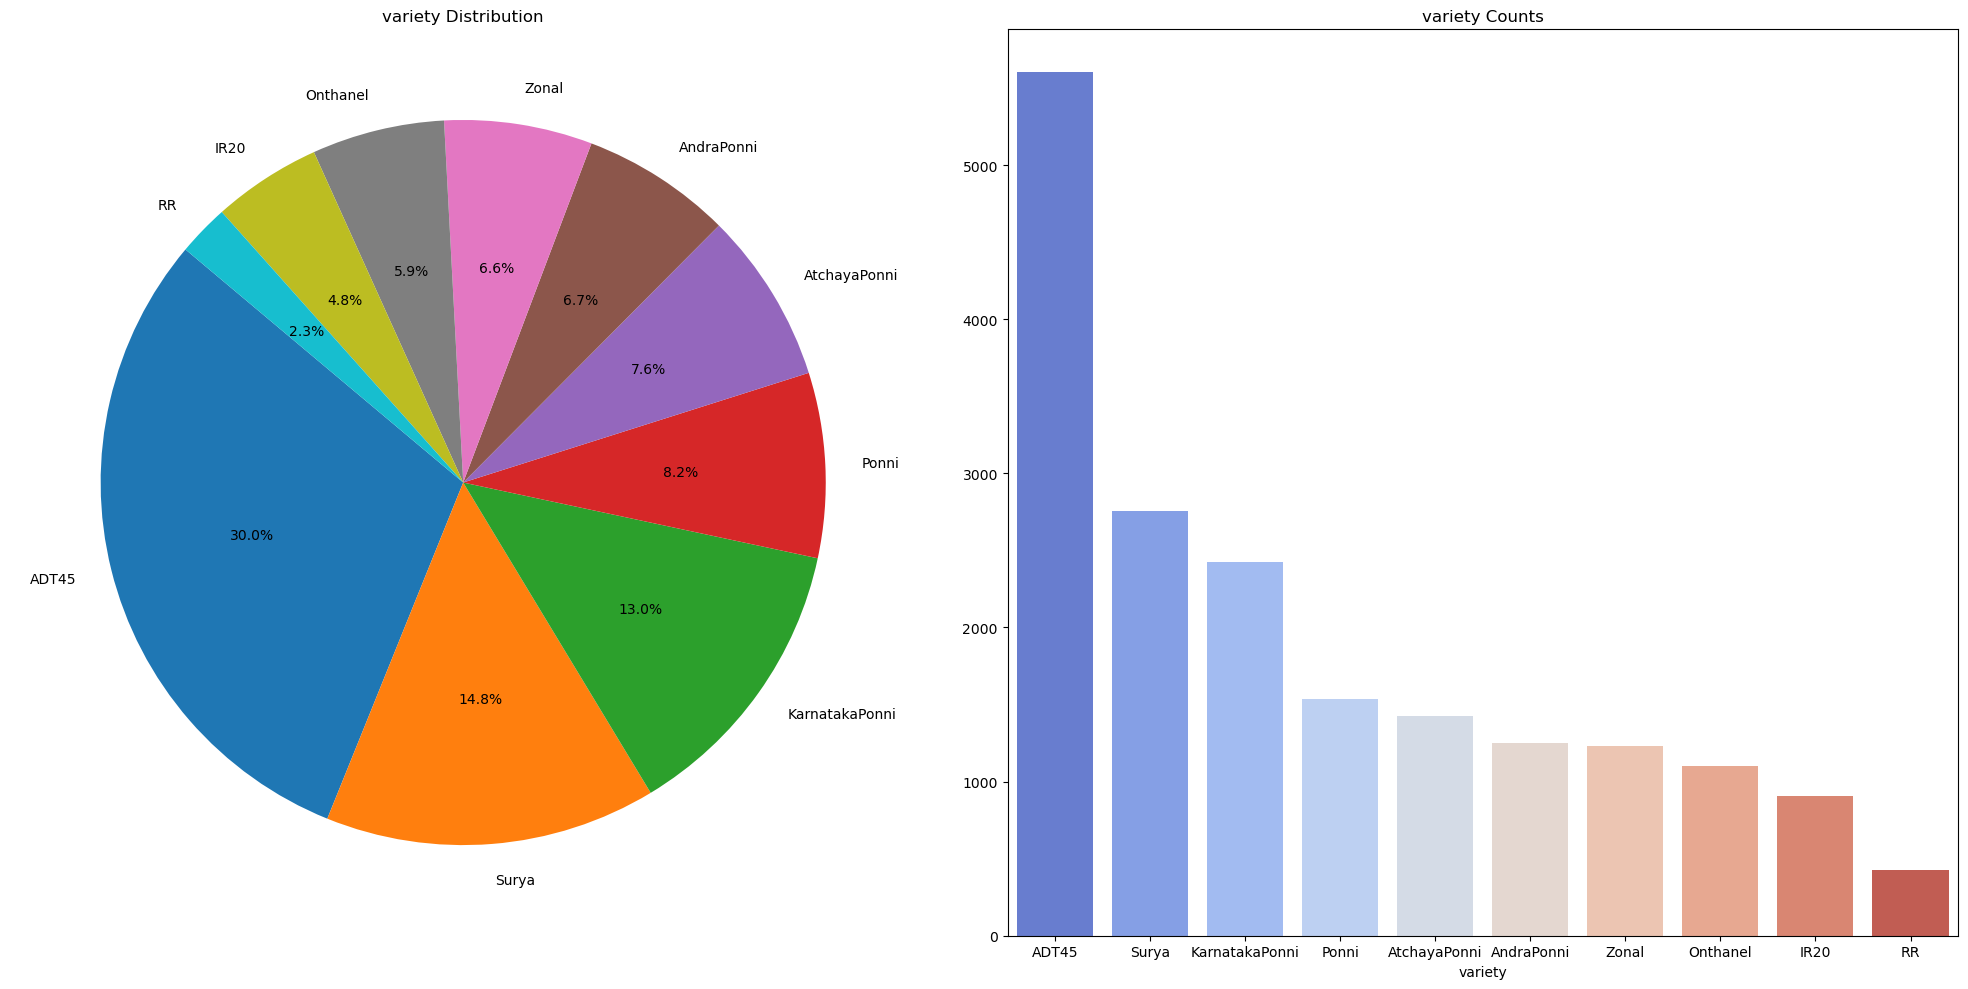

In [12]:
vi.visualize_category_distribution(final_df,"variety")

The final solution is to cut the ADT45 by 3000 values to get it down to normal

In [61]:

n_remove = 3000

adt45_df = final_df[final_df['variety'] == 'ADT45']
other_df = final_df[final_df['variety'] != 'ADT45']

adt45_reduced = adt45_df.sample(n=len(adt45_df) - n_remove, random_state=42)

final_df = pd.concat([adt45_reduced, other_df], ignore_index=True)

print(final_df['variety'].value_counts())

variety
Surya             2757
ADT45             2601
KarnatakaPonni    2427
Ponni             1539
AtchayaPonni      1428
AndraPonni        1252
Zonal             1232
Onthanel          1104
IR20               904
RR                 428
Name: count, dtype: int64


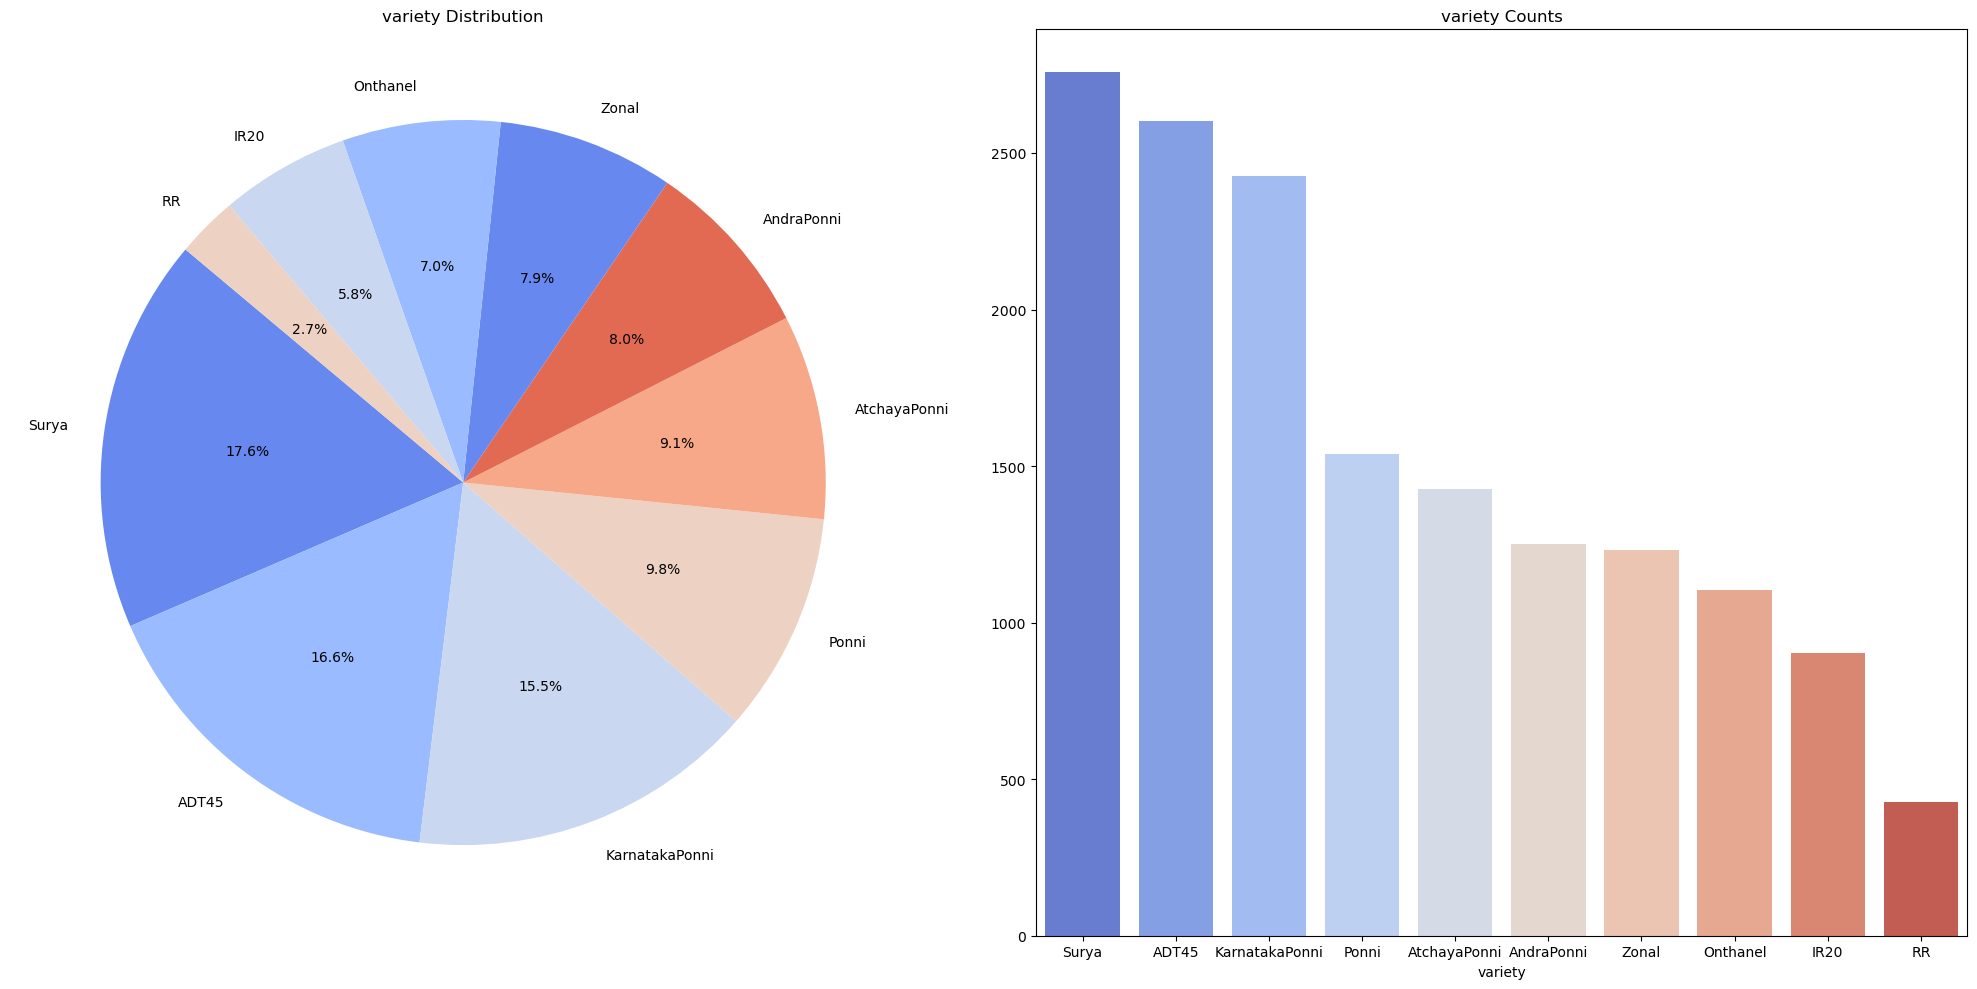

In [145]:
vi.visualize_category_distribution(final_df,"variety")

In [ ]:
task2_train = ImageDataGenerator(data_format='channels_last')
task2_generator = task2_train.flow_from_dataframe(
    dataframe=final_df,
    directory='',
    x_col='image_path',
    y_col='variety',
    target_size= (64,64),
    batch_size= 32,
    class_mode='categorical',
    seed=42,
    shuffle = False
)

Found 15672 validated image filenames belonging to 10 classes.


There are tisk of  losing important variations and features unique to ADT45, which could negatively impact the model’s ability but the cut was necessary to mitigate the class imbalance that would otherwise cause the model to be biased toward the overrepresented ADT45.


## 6) Paddy Field Variety Classification Model Selection

Challenge: Class Imbalance
In this paddy field variety classification task, **ADT45** is overwhelmingly dominant in the dataset. Despite using semi-supervised learning and data augmentation, the dataset is still imbalanced leading to model bias towards predicting ADT45.

with the predetermined criterias for model selections and the challenges of class imbalance, EfficientNet and ResNet are selected for model training
**EfficientNet**

1. **Efficient Architecture for Fine-grained Classification**:
   EfficientNet uses a compound scaling method that balances **accuracy** and **computational efficiency**. Its scalability helps in fine-grained tasks like distinguishing paddy varieties, even with an imbalanced dataset.

2. **Robust Feature Extraction**:
   Pre-trained on ImageNet, EfficientNet extracts rich features, helping it recognize even subtle differences between varieties.

3. **Transfer Learning**:
   EfficientNet benefits from transfer learning, speeding up training and reducing the impact of class imbalance by leveraging pre-trained knowledge.

4. **Improved Generalization**:
   Its design promotes **better generalization** to unseen data, reducing overfitting, a common issue with imbalanced datasets.

 **ResNet50**

1. **Residual Connections**:
   ResNet50 uses **residual connections** to make training deeper networks easier, enabling it to learn hierarchical patterns essential for distinguishing between paddy varieties.

2. **Learning Robust Representations**:
   The deep architecture allows ResNet50 to learn **robust representations**, capturing complex features that differentiate subtle classes.

3. **Mitigating Overfitting**:
   Pre-training on large datasets like ImageNet and fine-tuning helps prevent overfitting, ensuring that even minority classes are adequately learned.

4. **Works Well with Data Augmentation**:
   ResNet50 handles augmented data well, improving model generalization even when some classes are underrepresented.

Addressing Class Imbalance

- **Feature Extraction**: Both models excel at extracting distinguishing features from imbalanced data.
- **Transfer Learning**: Using pre-trained models ensures that the models rely on general features to make better predictions.
- **Fine-tuning**: Techniques like class weighting and adaptive learning rates help mitigate class imbalance.

### 6.1) **EfficientNetB0 vs ResNet50 for Paddy Field Classification**

| **Metric**                  | **EfficientNetB0**                                                                 | **ResNet50**                                                            |
|-----------------------------|-----------------------------------------------------------------------------------|-------------------------------------------------------------------------|
| **1. Performance Metrics**   |                                                                                   |                                                                         |
| Accuracy, Precision, Recall, F1-score | Achieves high accuracy, precision, recall, and F1-score due to compound scaling and efficiency. | Good performance but may require more fine-tuning.                     |
| AUC-ROC                     | Tends to be high due to better generalization and balanced performance across classes. | Solid, but might not be as high as EfficientNetB0 for complex multi-class tasks. |
| Generalization              | High generalization ability due to compound scaling mechanism.                      | May be affected by the number of layers and risk of overfitting.        |
| **2. Cost Metrics**          |                                                                                   |                                                                         |
| Training Time               | Relatively fast due to fewer parameters and efficient architecture.                | Slower due to a higher number of parameters.                           |
| Inference Time              | Fast inference time, especially in resource-constrained environments.              | Inference may be slightly slower due to more parameters.                |
| Resource Usage              | Efficient in terms of memory and computational resources.                          | More resource-intensive, requiring more memory and computational power. |
| **3. Risk Metrics**          |                                                                                   |                                                                         |
| Robustness                  | Robust against noise and missing data due to well-designed architecture.           | Relatively robust but may need additional regularization.               |
| Overfitting Risk            | Less risk of overfitting due to smaller parameter count and efficient regularization. | Higher risk of overfitting unless regularization strategies are used.   |
| Bias and Fairness           | Reduced risk of bias, with a balanced approach to scaling.                         | Potential for bias if not carefully tuned for diverse data.             |
| **4. Compatibility**         |                                                                                   |                                                                         |
| Integration                 | Easily integrable into cloud or edge devices due to lightweight design.           | Integrates well into cloud environments but may need adaptation for edge devices. |
| Data Formats                | Can accept various sensor or imaging device data formats with flexible preprocessing. | Supports common data formats but preprocessing may be more specific.    |
| **5. Maintainability and Transferability** |                                                                                   |                                                                         |
| Ease of Update              | Can be retrained or fine-tuned efficiently with minimal computational overhead.     | Requires more resources and time compared to EfficientNetB0.            |
| Documentation               | Well-documented architecture and training process, supported by the broader EfficientNet framework. | Comprehensive documentation available but may require more technical understanding. |
| Transferability             | Easily adapted to new regions or varieties with fine-tuning and minimal adjustments. | Adaptable but fine-tuning may require more effort due to model complexity. |


In [193]:

efficientnet = EfficientNetB0(input_shape=(64, 64, 3), include_top=False, weights=None)

resnet = ResNet50(input_shape=(64, 64, 3), include_top=False, weights=None)

tr.analyze_model_layers(efficientnet, "EfficientNetB0")
tr.analyze_model_layers(resnet, "ResNet50")

def create_full_model(base_model, model_name):
    model = models.Sequential(
        [
            base_model
        ]
    )
    return model


efficientnet_full = create_full_model(efficientnet, "EfficientNetB0")
resnet_full = create_full_model(resnet, "ResNet50")

efficientnet_full.summary()
resnet_full.summary()


=== EfficientNetB0 Layer Analysis ===
Total number of layers: 237

Layer type distribution:
InputLayer: 1
Rescaling: 1
Normalization: 1
ZeroPadding2D: 5
Conv2D: 65
BatchNormalization: 49
Activation: 33
DepthwiseConv2D: 16
GlobalAveragePooling2D: 16
Reshape: 16
Multiply: 16
Dropout: 9
Add: 9

Total trainable parameters: 4,049,571

=== ResNet50 Layer Analysis ===
Total number of layers: 175

Layer type distribution:
InputLayer: 1
ZeroPadding2D: 2
Conv2D: 53
BatchNormalization: 53
Activation: 49
MaxPooling2D: 1
Add: 16

Total trainable parameters: 23,587,712
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 2, 2, 1280)       4049571   
                                                                 
Total params: 4,049,571
Trainable params: 4,007,548
Non-trainable params: 42,023
_________________________________________________________________
Mod

### 6.2) EfficientnetB0 training

In [68]:
def create_efficientnetb0_model():
    base_model = tf.keras.applications.EfficientNetB0(
        input_shape=(64, 64, 3),
        include_top=False,
        weights=None,  
        pooling="avg",
    )
    model = models.Sequential([base_model, layers.Dense(10, activation="softmax")])
    return model


# Create and compile model
model = create_efficientnetb0_model()
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy", 
    metrics=["accuracy"],
)

# Train model
history = model.fit(
    task2_generator,  
    validation_data=val_generator,  
    epochs=15,
    verbose=1,
)

Epoch 1/15
490/490 [==============================] - 602s 1s/step - loss: 1.6343 - accuracy: 0.4370 - val_loss: 2.1544 - val_accuracy: 0.2930
Epoch 2/15
490/490 [==============================] - 572s 1s/step - loss: 0.9166 - accuracy: 0.6856 - val_loss: 1.0451 - val_accuracy: 0.6028
Epoch 3/15
490/490 [==============================] - 410s 836ms/step - loss: 0.5362 - accuracy: 0.8210 - val_loss: 0.9999 - val_accuracy: 0.6844
Epoch 4/15
490/490 [==============================] - 468s 956ms/step - loss: 0.3600 - accuracy: 0.8851 - val_loss: 0.5870 - val_accuracy: 0.8084
Epoch 5/15
490/490 [==============================] - 410s 836ms/step - loss: 0.2706 - accuracy: 0.9147 - val_loss: 0.4995 - val_accuracy: 0.8425
Epoch 6/15
490/490 [==============================] - 582s 1s/step - loss: 0.2178 - accuracy: 0.9296 - val_loss: 0.5789 - val_accuracy: 0.8271
Epoch 7/15
490/490 [==============================] - 428s 873ms/step - loss: 0.2046 - accuracy: 0.9368 - val_loss: 0.4013 - val_accu

In [69]:
mt.save_model_and_history(model, history, "efficientnet_final")

INFO:tensorflow:Assets written to: ram://1c3dfea6-17e2-4c54-b238-e8ff18f557da/assets


INFO:tensorflow:Assets written to: ram://1c3dfea6-17e2-4c54-b238-e8ff18f557da/assets


Model saved to models\efficientnet_final.keras
Full history saved to models/history\efficientnet_final_history.pkl


In [ ]:
model_path = "./models/efficientnet_final.keras"
if os.path.exists(model_path):
    print("Loading saved model...")
    efficientnet_best_model = load_model(model_path)

66/66 [==============================] - 11s 143ms/step


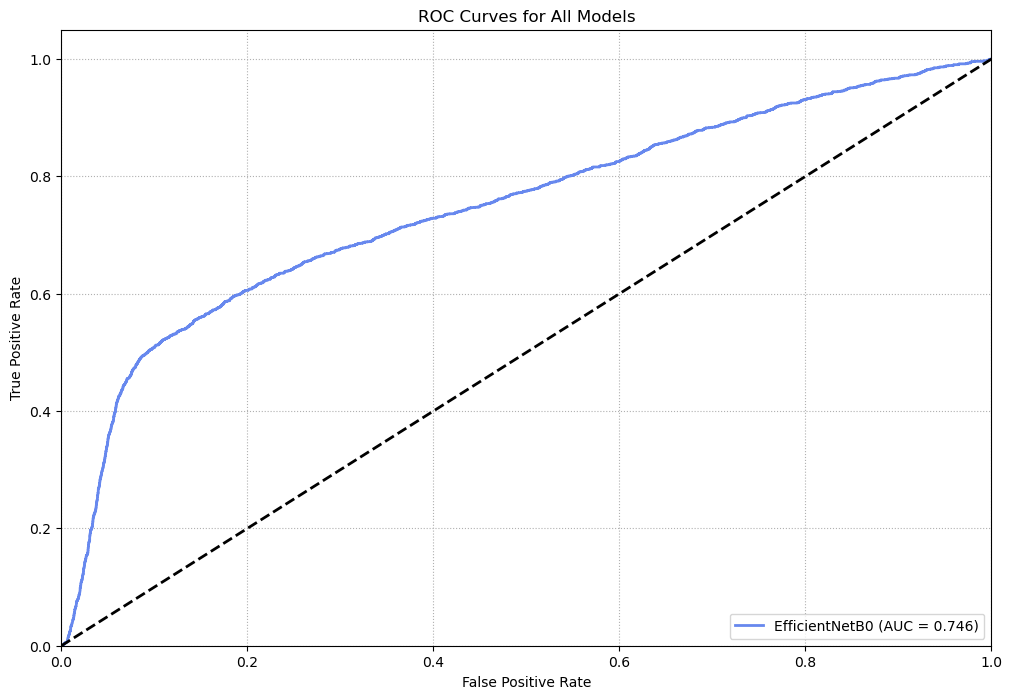

In [81]:
tr.plot_roc_curves(
    [model],
    ['EfficientNetB0'],
    val_generator,
    num_classes= 10
)

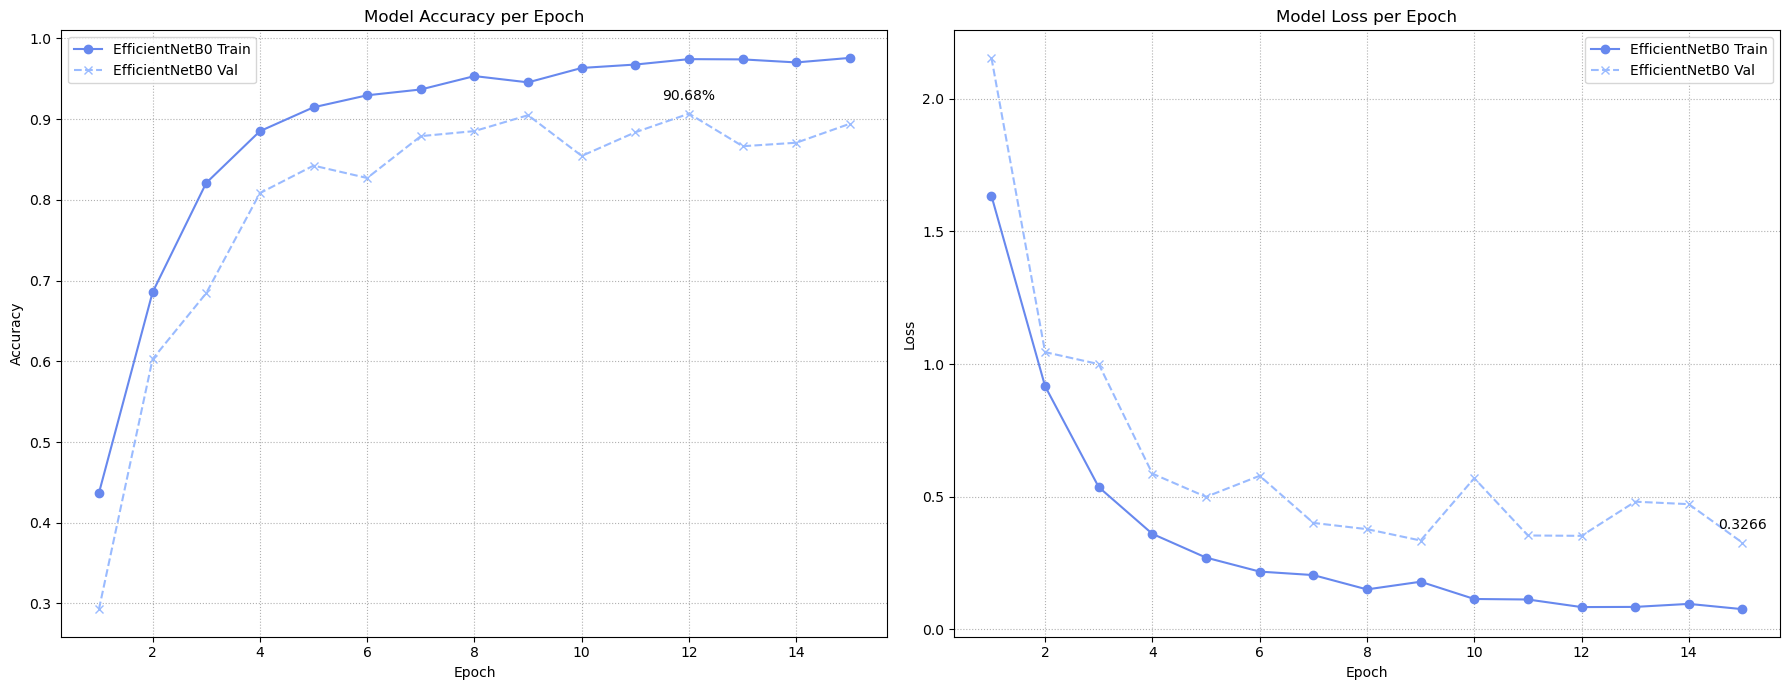

In [87]:
tr.plot_history([history], ["EfficientNetB0"])


In [92]:
train_loss, train_accuracy = efficientnet_best_model.evaluate(train_generator,verbose=1)

print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

val_loss, val_accuracy = efficientnet_best_model.evaluate(val_generator, verbose=1)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

498/498 [==============================] - 61s 120ms/step - loss: 0.1208 - accuracy: 0.9614
Training Loss: 0.1208
Training Accuracy: 0.9614
66/66 [==============================] - 9s 140ms/step - loss: 0.3266 - accuracy: 0.8943
Validation Loss: 0.3266
Validation Accuracy: 0.8943


In [96]:
# Use your validation generator (replace 'val_generator' with your actual generator variable)
mt.evaluate_model(efficientnet_best_model, val_generator, "EfficientNetB0 Paddy Classifier")

66/66 [==============================] - 13s 197ms/step
--- EfficientNetB0 Paddy Classifier ---
Accuracy : 0.8943
Precision: 0.9105
Recall   : 0.8943
F1-score : 0.8983

Classification Report:
                precision    recall  f1-score   support

         ADT45       0.97      0.89      0.92      1391
    AndraPonni       0.61      0.94      0.74        64
  AtchayaPonni       0.85      0.88      0.87       104
          IR20       0.88      0.93      0.90        15
KarnatakaPonni       0.90      0.85      0.87       179
      Onthanel       0.80      0.92      0.86        75
         Ponni       0.73      0.96      0.83       144
            RR       0.57      1.00      0.73         8
         Surya       0.33      0.55      0.41        11
         Zonal       0.86      0.99      0.92        91

      accuracy                           0.89      2082
     macro avg       0.75      0.89      0.80      2082
  weighted avg       0.91      0.89      0.90      2082





### 6.3) Resnet50 Training

In [41]:

resnet50_model = models.Sequential(
    [
        ResNet50(
            input_shape=(64, 64, 3),
            include_top=False,
            weights=None,  
            pooling="avg",
        ),
        layers.Dense(10, activation="softmax"),
    ]
)

resnet50_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",  
    metrics=["accuracy"],
)

resnet50_history = resnet50_model.fit(
    task2_generator, validation_data=val_generator, epochs=15, verbose=2
)

Epoch 1/15
584/584 - 627s - loss: 1.3048 - accuracy: 0.6163 - val_loss: 2.4658 - val_accuracy: 0.4385 - 627s/epoch - 1s/step
Epoch 2/15
584/584 - 474s - loss: 0.6427 - accuracy: 0.8047 - val_loss: 0.5704 - val_accuracy: 0.8228 - 474s/epoch - 812ms/step
Epoch 3/15
584/584 - 491s - loss: 0.4145 - accuracy: 0.8800 - val_loss: 1.2248 - val_accuracy: 0.6451 - 491s/epoch - 840ms/step
Epoch 4/15
584/584 - 471s - loss: 0.4047 - accuracy: 0.8887 - val_loss: 73.9194 - val_accuracy: 0.3617 - 471s/epoch - 807ms/step
Epoch 5/15
584/584 - 554s - loss: 0.4569 - accuracy: 0.8650 - val_loss: 0.6680 - val_accuracy: 0.8180 - 554s/epoch - 948ms/step
Epoch 6/15
584/584 - 490s - loss: 0.2088 - accuracy: 0.9341 - val_loss: 0.2677 - val_accuracy: 0.9126 - 490s/epoch - 840ms/step
Epoch 7/15
584/584 - 515s - loss: 0.1533 - accuracy: 0.9500 - val_loss: 0.6063 - val_accuracy: 0.8208 - 515s/epoch - 882ms/step
Epoch 8/15
584/584 - 471s - loss: 0.1499 - accuracy: 0.9530 - val_loss: 0.1951 - val_accuracy: 0.9443 - 47

In [48]:
resnet50_model.save("./models/resnet50_paddy_classifier.keras")

In [45]:
with open('./models/history/resnet50_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

### 6.4) RESULTS COMPARISON

#### 6.4.1) History

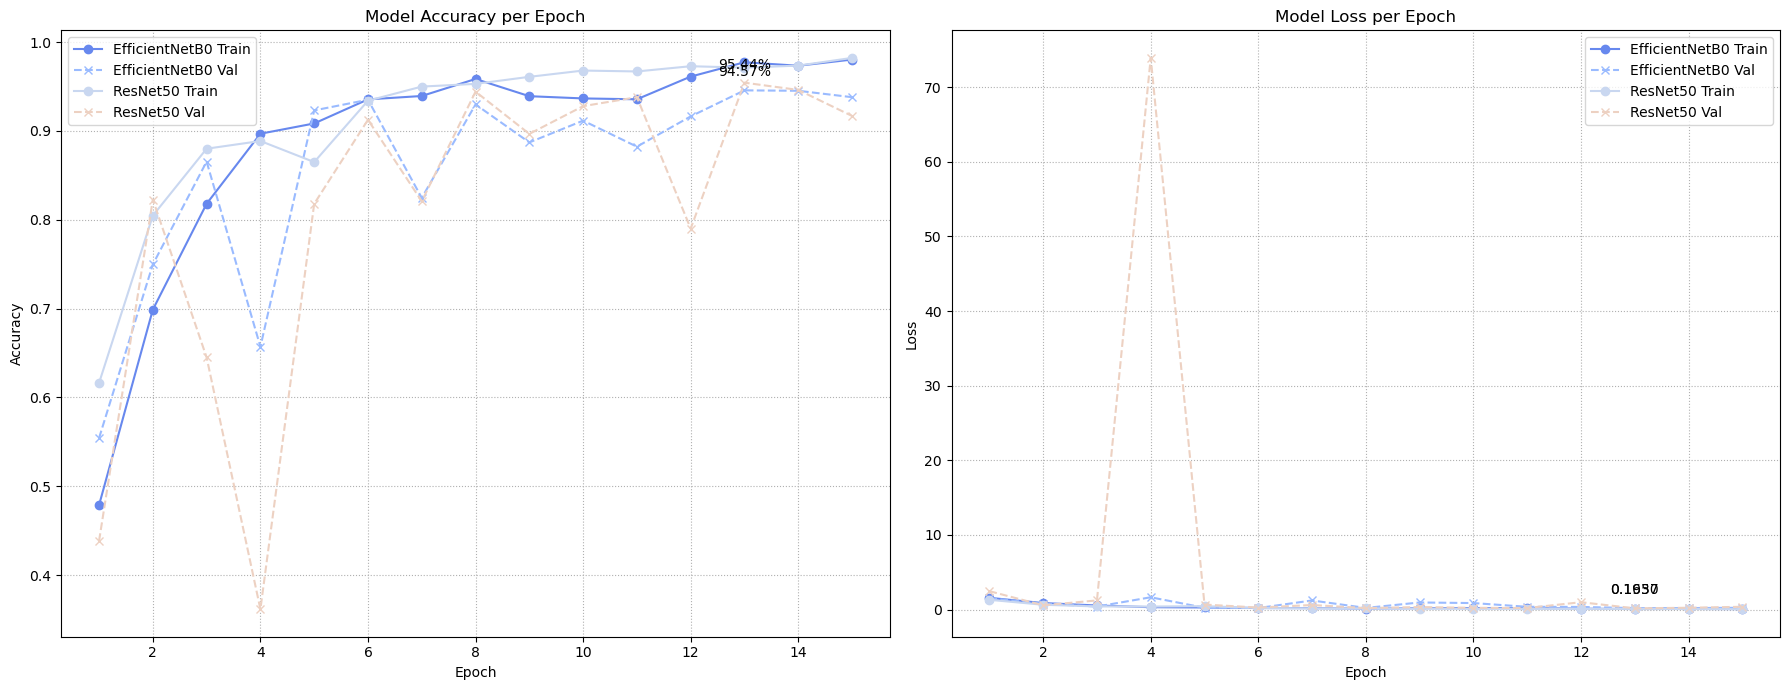

In [42]:
tr.plot_history([history, resnet50_history], ["EfficientNetB0", "ResNet50"])

#### 6.4.2) ROC curve

66/66 [==============================] - 13s 179ms/step


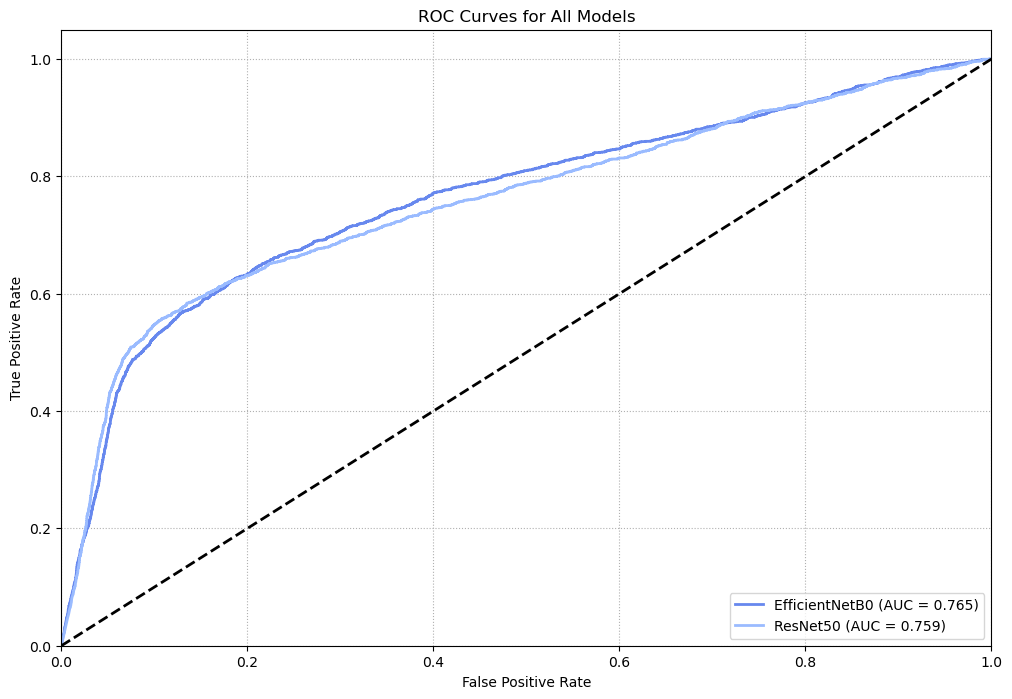

In [43]:
tr.plot_roc_curves(
    [model, resnet50_model],
    ['EfficientNetB0', 'ResNet50'],
    val_generator,
    num_classes= 10
)

In [44]:
tr.evaluate_model(model, val_generator, "effientNet")

66/66 [==============================] - 10s 143ms/step
--- effientNet ---
Accuracy : 0.4486
Precision: 0.4690
Recall   : 0.4486
F1-score : 0.4583

Classification Report:
                precision    recall  f1-score   support

         ADT45       0.67      0.64      0.65      1391
    AndraPonni       0.05      0.05      0.05        64
  AtchayaPonni       0.04      0.04      0.04       104
          IR20       0.00      0.00      0.00        15
KarnatakaPonni       0.09      0.11      0.10       179
      Onthanel       0.02      0.03      0.03        75
         Ponni       0.08      0.08      0.08       144
            RR       0.00      0.00      0.00         8
         Surya       0.09      0.09      0.09        11
         Zonal       0.09      0.10      0.09        91

      accuracy                           0.45      2082
     macro avg       0.11      0.11      0.11      2082
  weighted avg       0.47      0.45      0.46      2082





### 7) EfficientNetB0 Fine Tuning
Training Stability
One of the significant observations during the training process was the instability in the validation accuracy of ResNet50. This could be attributed to the deeper architecture of ResNet50, which, while powerful, may lead to overfitting or difficulty in generalizing during certain stages of training.

 Performance
 the stability of **EfficientNetB0** was a higher making it better suited for the variety classification task, where stable predictions are crucial for real-world application.

Model Complexity and Efficiency
**EfficientNetB0** is comparatively lighter in terms of the number of parameters and computational resources required. Given the constraints of the problem (classification of multiple paddy varieties), the efficiency of EfficientNetB0 ensures quicker inference times and reduced resource consumption

Layer Size and Resource Utilization
The EfficientNet series is designed to optimize model performance without excessive computational cost. Given that the task at hand involves a multi-class classification with a relatively large dataset, the computational advantages of EfficientNetB0 make it a better fit in terms of scalability and adaptability.


### 7.1) class weight

As mentioned in the data augmented section, we shall use class weight for handling the imbalanced data.

we get the class labels to compute the class weights

In [19]:
class_labels = task2_generator.classes

Class weight is set to balanced compute weights that are inversely proportional to class frequencies. This means that underrepresented classes will get higher weights, and overrepresented classes will get lower weights to balanced out the heavily biased variety classes

In [20]:
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(class_labels), y=class_labels
)

finally, this converts the class_weights array into a dictionary. The dictionary will have the class indices as keys and the computed class weights as the corresponding values. 

In [21]:
class_weight_dict = dict(enumerate(class_weights))


### 7.2 EfficientNetB0 Advanced Model Overview

This model uses the **EfficientNetB0** architecture as the base with added layers and techniques for improved performance.

Model Layers:

1. **EfficientNetB0 (Base Model)**  
   - Excludes top layers (`include_top=False`) for transfer learning.
   - Uses global average pooling (`pooling='avg'`) to reduce feature maps.

2. **Dropout**  
   - **30%** dropout in the first layer and **20%** in the second to prevent overfitting. Higher dropout in earlier layers helps regularize deep networks.

3. **Dense Layer (Hidden)**  
   - **128 units with ReLU activation**: Provides sufficient complexity for learning.
   - **L2 regularization (`regularizers.l2(0.0001)`)**: Prevents large weights, improving generalization and reducing overfitting.

4. **Dense Layer (Output)**  
   - **Softmax activation** with `NUM_CLASSES` neurons for multi-class classification.
   - **L2 regularization (`regularizers.l2(0.001)`)**: Stronger regularization on the output layer to reduce overfitting and control complexity.


In [63]:
subsetdf, _ = train_test_split(
    final_df, test_size=0.8, stratify=final_df["variety"], random_state=42
)

In [33]:
subset_train_df, subset_val_df = train_test_split(
    subsetdf, test_size=0.2, stratify=subsetdf["variety"], random_state=42
)

train_subset_generator = train_datagen.flow_from_dataframe(
    dataframe=subset_train_df,
    x_col="image_path",
    y_col="variety",
    target_size=(128, 128),
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
)

val_subset_generator = val_datagen.flow_from_dataframe(
    dataframe=subset_val_df,
    x_col="image_path",
    y_col="variety",
    target_size=(128, 128),
    class_mode="categorical",
    batch_size=32,
    shuffle=False,
)

Found 2987 validated image filenames belonging to 10 classes.
Found 747 validated image filenames belonging to 10 classes.


In [ ]:
lambda_parameters = [0.0001, 0.001, 0.005, 0.01]
model_results = {}

for para_l2_strength in lambda_parameters:
    print(f"\nTraining EfficientNetB0 with L2 regularization lambda = {para_l2_strength}")

    
    efficientnet_model = models.Sequential([
        EfficientNetB0(
            input_shape=(128, 128, 3),
            include_top=False,
            weights=None,
            pooling='avg'
        ),
        layers.Dropout(0.3),
        layers.Dense(
            128,
            activation='relu',
            kernel_regularizer=regularizers.l2(para_l2_strength)
        ),
        layers.Dropout(0.2),
        layers.Dense(
            10,
            activation='softmax',
            kernel_regularizer=regularizers.l2(para_l2_strength)
        )
    ])

    efficientnet_model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    early_stopping = EarlyStopping(
        monitor="val_accuracy", patience=15, restore_best_weights=True
    )

    history = efficientnet_model.fit(
        train_subset_generator,
        validation_data=val_subset_generator,
        epochs=25,
        callbacks=[early_stopping],
        verbose=1,
    )

    # Save model and history
    model_name = f"efficientnetb0_{para_l2_strength}_lambda"
    mt.save_model_and_history(efficientnet_model, history, model_name)

    # Store final accuracies
    best_epoch = np.argmax(history.history["val_accuracy"])
    val_acc = history.history["val_accuracy"][best_epoch]
    train_acc = history.history["accuracy"][best_epoch]

    model_results[model_name] = (train_acc, val_acc)

# sort lambda value
model_results = dict(
    sorted(model_results.items(), key=lambda x: float(x[0].split("_")[1]))
)



Training EfficientNetB0 with L2 regularization lambda = 0.0001
Epoch 1/25
94/94 [==============================] - 234s 2s/step - loss: 1.9994 - accuracy: 0.3278 - val_loss: 2.4009 - val_accuracy: 0.1486
Epoch 2/25
94/94 [==============================] - 286s 3s/step - loss: 1.6920 - accuracy: 0.4359 - val_loss: 2.5189 - val_accuracy: 0.1486
Epoch 3/25
94/94 [==============================] - 314s 3s/step - loss: 1.4783 - accuracy: 0.4928 - val_loss: 4.6609 - val_accuracy: 0.1486
Epoch 4/25
94/94 [==============================] - 301s 3s/step - loss: 1.2291 - accuracy: 0.5875 - val_loss: 2.4900 - val_accuracy: 0.2169
Epoch 5/25
94/94 [==============================] - 285s 3s/step - loss: 0.9663 - accuracy: 0.6813 - val_loss: 2.9911 - val_accuracy: 0.2972
Epoch 6/25
94/94 [==============================] - 250s 3s/step - loss: 0.8131 - accuracy: 0.7369 - val_loss: 2.0513 - val_accuracy: 0.5127
Epoch 7/25
94/94 [==============================] - 88s 940ms/step - loss: 0.6739 - accura

INFO:tensorflow:Assets written to: ram://b549cd99-e39e-4823-81e0-5cd19ba20ec7/assets


INFO:tensorflow:Assets written to: ram://b549cd99-e39e-4823-81e0-5cd19ba20ec7/assets


Model saved to models\efficientnetb0_0.0001_lambda.keras
Full history saved to models/history\efficientnetb0_0.0001_lambda_history.pkl

Training EfficientNetB0 with L2 regularization lambda = 0.001
Epoch 1/25
94/94 [==============================] - 110s 979ms/step - loss: 2.2218 - accuracy: 0.3472 - val_loss: 2.5037 - val_accuracy: 0.2999
Epoch 2/25
94/94 [==============================] - 90s 954ms/step - loss: 1.9112 - accuracy: 0.4436 - val_loss: 4.3833 - val_accuracy: 0.1486
Epoch 3/25
94/94 [==============================] - 89s 944ms/step - loss: 1.6710 - accuracy: 0.5176 - val_loss: 6.4226 - val_accuracy: 0.1486
Epoch 4/25
94/94 [==============================] - 88s 937ms/step - loss: 1.4311 - accuracy: 0.5993 - val_loss: 3.1168 - val_accuracy: 0.1700
Epoch 5/25
94/94 [==============================] - 90s 959ms/step - loss: 1.2452 - accuracy: 0.6562 - val_loss: 3.1994 - val_accuracy: 0.2343
Epoch 6/25
94/94 [==============================] - 89s 943ms/step - loss: 0.9761 - ac

INFO:tensorflow:Assets written to: ram://589b2143-7987-49e5-990a-bc882697aa5e/assets


INFO:tensorflow:Assets written to: ram://589b2143-7987-49e5-990a-bc882697aa5e/assets


Model saved to models\efficientnetb0_0.001_lambda.keras
Full history saved to models/history\efficientnetb0_0.001_lambda_history.pkl

Training EfficientNetB0 with L2 regularization lambda = 0.005
Epoch 1/25
94/94 [==============================] - 120s 1s/step - loss: 3.0951 - accuracy: 0.3391 - val_loss: 3.2728 - val_accuracy: 0.1486
Epoch 2/25
94/94 [==============================] - 97s 1s/step - loss: 2.5564 - accuracy: 0.4165 - val_loss: 3.3604 - val_accuracy: 0.0669
Epoch 3/25
94/94 [==============================] - 97s 1s/step - loss: 2.1361 - accuracy: 0.4844 - val_loss: 5.9032 - val_accuracy: 0.1486
Epoch 4/25
94/94 [==============================] - 97s 1s/step - loss: 1.8212 - accuracy: 0.5547 - val_loss: 4.0799 - val_accuracy: 0.2021
Epoch 5/25
94/94 [==============================] - 97s 1s/step - loss: 1.4913 - accuracy: 0.6371 - val_loss: 2.7830 - val_accuracy: 0.2945
Epoch 6/25
94/94 [==============================] - 97s 1s/step - loss: 1.2170 - accuracy: 0.7071 - val

INFO:tensorflow:Assets written to: ram://2c43dfe6-3613-413a-a0b5-28a9ea6dcf23/assets


INFO:tensorflow:Assets written to: ram://2c43dfe6-3613-413a-a0b5-28a9ea6dcf23/assets


Model saved to models\efficientnetb0_0.005_lambda.keras
Full history saved to models/history\efficientnetb0_0.005_lambda_history.pkl

Training EfficientNetB0 with L2 regularization lambda = 0.01
Epoch 1/25
94/94 [==============================] - 117s 1s/step - loss: 3.9736 - accuracy: 0.3485 - val_loss: 3.8789 - val_accuracy: 0.1486
Epoch 2/25
94/94 [==============================] - 99s 1s/step - loss: 2.9137 - accuracy: 0.4479 - val_loss: 3.8646 - val_accuracy: 0.0843
Epoch 3/25
94/94 [==============================] - 95s 1s/step - loss: 2.2266 - accuracy: 0.5229 - val_loss: 5.4755 - val_accuracy: 0.1486
Epoch 4/25
94/94 [==============================] - 96s 1s/step - loss: 1.7300 - accuracy: 0.6003 - val_loss: 5.4204 - val_accuracy: 0.1673
Epoch 5/25
94/94 [==============================] - 96s 1s/step - loss: 1.3862 - accuracy: 0.6722 - val_loss: 2.6893 - val_accuracy: 0.2758
Epoch 6/25
94/94 [==============================] - 95s 1s/step - loss: 1.0878 - accuracy: 0.7503 - val_

INFO:tensorflow:Assets written to: ram://3147ed0f-a8e2-4e93-acc3-03dd52de4da8/assets


INFO:tensorflow:Assets written to: ram://3147ed0f-a8e2-4e93-acc3-03dd52de4da8/assets


Model saved to models\efficientnetb0_0.01_lambda.keras
Full history saved to models/history\efficientnetb0_0.01_lambda_history.pkl


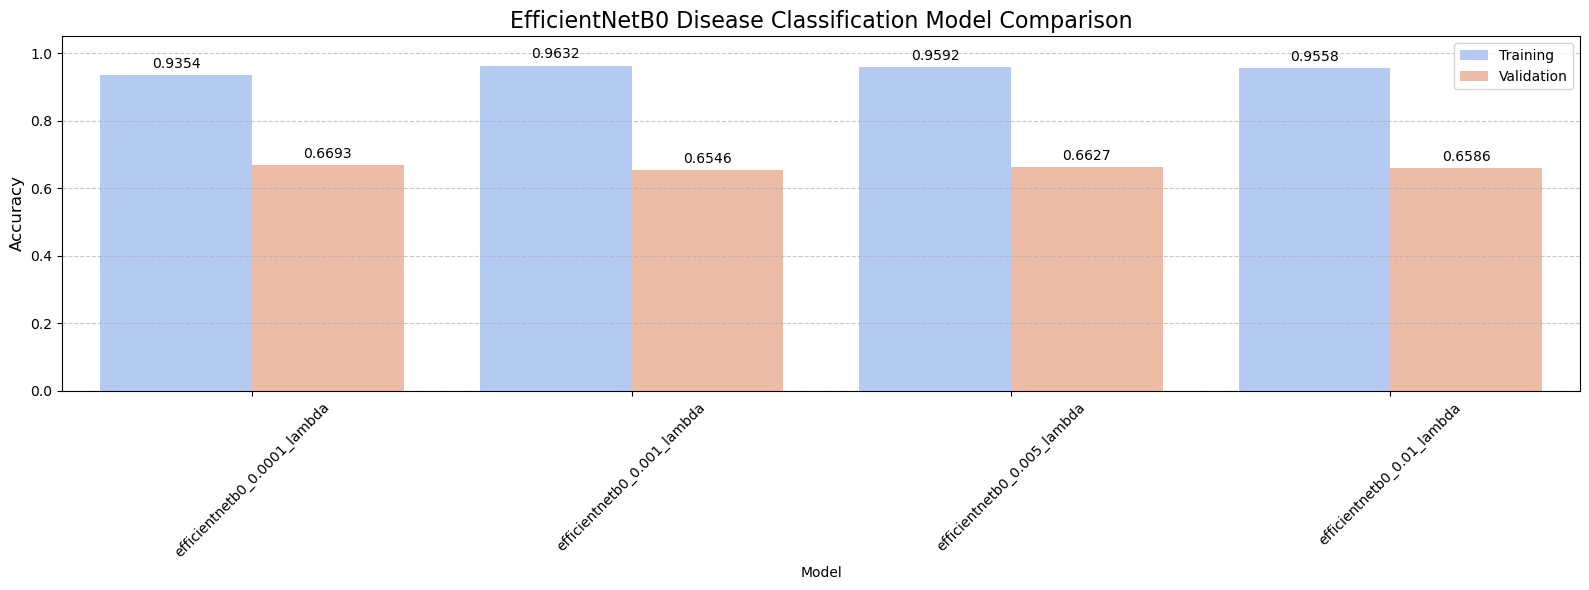

In [40]:

mt.plot_model_results(
    model_results, "EfficientNetB0 Disease Classification Model Comparison", figsize=(16, 6)
)

In [97]:
efficientnet_adv = models.Sequential([
    EfficientNetB0(
        input_shape=(128, 128, 3),
        include_top=False,
        weights=None,
        pooling='avg'
    ),
    layers.BatchNormalization(),  
    layers.Dropout(0.4),          
    layers.Dense(
        256,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.0001)
    ),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(
        128,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.0001)
    ),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(
        OUTPUT_CLASSES,
        activation='softmax',
        kernel_regularizer=regularizers.l2(0.0001)
    )
])

compile the model with a lower learning rate of 0.0005 and use reducLROnPlateau for the adaptive learning rate

In [98]:
efficientnet_adv.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6
)

Set early stopping and Checkpoint to save the best model and to prevent unnecessary epochs

In [99]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)
model_ckpt = callbacks.ModelCheckpoint(
    'efficientnetb0_advanced_best.h5', save_best_only=True, monitor='val_loss'
)

In [100]:
history = efficientnet_adv.fit(
    task2_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, model_ckpt, reduce_lr],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/30
490/490 [==============================] - 338s 662ms/step - loss: 2.5804 - accuracy: 0.2194 - val_loss: 3.2250 - val_accuracy: 0.0423 - lr: 5.0000e-04
Epoch 2/30
490/490 [==============================] - 306s 624ms/step - loss: 2.0940 - accuracy: 0.3326 - val_loss: 2.6690 - val_accuracy: 0.1306 - lr: 5.0000e-04
Epoch 3/30
490/490 [==============================] - 308s 627ms/step - loss: 1.7552 - accuracy: 0.4277 - val_loss: 2.5095 - val_accuracy: 0.1686 - lr: 5.0000e-04
Epoch 4/30
490/490 [==============================] - 308s 628ms/step - loss: 1.4683 - accuracy: 0.4967 - val_loss: 2.4395 - val_accuracy: 0.1921 - lr: 5.0000e-04
Epoch 5/30
490/490 [==============================] - 306s 625ms/step - loss: 1.2252 - accuracy: 0.5736 - val_loss: 2.2741 - val_accuracy: 0.1931 - lr: 5.0000e-04
Epoch 6/30
490/490 [==============================] - 308s 628ms/step - loss: 0.9796 - accuracy: 0.6397 - val_loss: 1.9618 - val_accuracy: 0.2771 - lr: 5.0000e-04
Epoch 7/30
490/490 [==

In [101]:
mt.evaluate_model(efficientnet_adv,val_generator, "EfficientNetB0 fine tuned")

66/66 [==============================] - 10s 126ms/step
--- EfficientNetB0 Paddy Classifier ---
Accuracy : 0.9121
Precision: 0.9260
Recall   : 0.9121
F1-score : 0.9145

Classification Report:
                precision    recall  f1-score   support

         ADT45       0.99      0.89      0.93      1391
    AndraPonni       0.81      0.95      0.88        64
  AtchayaPonni       0.82      0.95      0.88       104
          IR20       0.87      0.87      0.87        15
KarnatakaPonni       0.81      0.96      0.88       179
      Onthanel       0.72      1.00      0.84        75
         Ponni       0.81      0.97      0.88       144
            RR       0.53      1.00      0.70         8
         Surya       0.67      0.73      0.70        11
         Zonal       0.83      1.00      0.91        91

      accuracy                           0.91      2082
     macro avg       0.79      0.93      0.85      2082
  weighted avg       0.93      0.91      0.91      2082





In [105]:
mt.save_model_and_history(efficientnet_adv, history, "efficientnet_final")

INFO:tensorflow:Assets written to: ram://137e5827-6a1f-4b53-80d5-64b649ad0493/assets


INFO:tensorflow:Assets written to: ram://137e5827-6a1f-4b53-80d5-64b649ad0493/assets


Model saved to models\efficientnet_final.keras
Full history saved to models/history\efficientnet_final_history.pkl


66/66 [==============================] - 7s 112ms/step


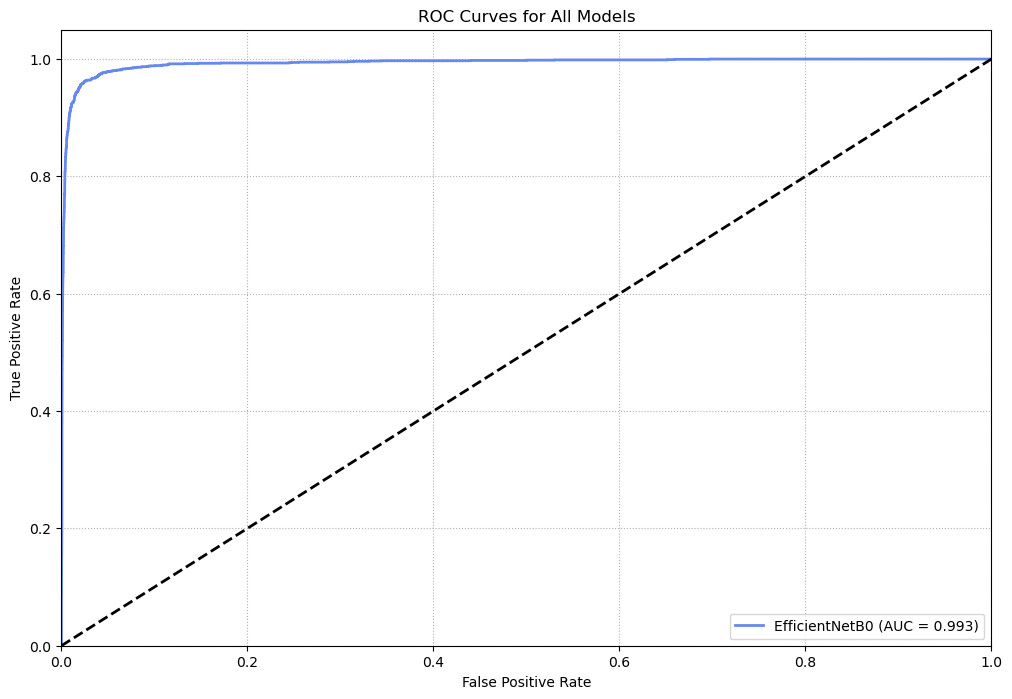

In [104]:
tr.plot_roc_curves(
    [efficientnet_adv],
    ['EfficientNetB0'],
    val_generator,
    num_classes= 10
)

In [ ]:

efficientnet_adv_model = keras.models.load_model("models/efficientnet_final.keras")

efficientnet_adv_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dropout_14 (Dropout)        (None, 1280)              0         
                                                                 
 dense_26 (Dense)            (None, 256)               327936    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_15 (Dropout)        (None, 256)             

## 8) Conclusion

The ROC curve demonstrates that the fine tuned EfficientNetB0 model has outstanding classification performance for this task. With an AUC of 0.993, it is highly reliable and effective at differentiating between the classes.

In [177]:
print(final_df["variety"].unique())
print(class_names_list)


['ADT45' 'AtchayaPonni' 'Ponni' 'Zonal' 'KarnatakaPonni' 'Onthanel' 'IR20'
 'AndraPonni' 'Surya' 'RR']
['ADT45', 'AndraPonni', 'AtchayaPonni', 'IR20', 'KarnatakaPonni', 'Onthanel', 'Ponni', 'RR', 'Surya', 'Zonal']



# V. MODEL PERFORMANCE VISUALIZATION

In [176]:
class_indices = task2_generator.class_indices

inv_class_indices = {v: k for k, v in class_indices.items()}
class_names_list = [inv_class_indices[i] for i in range(len(inv_class_indices))]

class_names_list


['ADT45',
 'AndraPonni',
 'AtchayaPonni',
 'IR20',
 'KarnatakaPonni',
 'Onthanel',
 'Ponni',
 'RR',
 'Surya',
 'Zonal']

In [187]:
# Step 1: Get filepaths from val_generator
gen_filepaths = val_generator.filepaths  # full paths
gen_filenames = [fp.split("/")[-1] for fp in gen_filepaths]  # just the filenames

# Step 2: Get filenames from val_df
df_filenames = val_df["image_path"].apply(lambda x: x.split("/")[-1]).tolist()

# Step 3: Compare first 10 items
print("Index | val_df filename        | generator filename")
print("------|------------------------|-------------------")
for i in range(10):
    print(f"{i:<5} | {df_filenames[i]:<22} | {gen_filenames[i]}")

Index | val_df filename        | generator filename
------|------------------------|-------------------
0     | 110123.jpg             | 110123.jpg
1     | 103408.jpg             | 103408.jpg
2     | 106214.jpg             | 106214.jpg
3     | 100525.jpg             | 100525.jpg
4     | 104673.jpg             | 104673.jpg
5     | 102229.jpg             | 102229.jpg
6     | 100874.jpg             | 100874.jpg
7     | 109401.jpg             | 109401.jpg
8     | 103165.jpg             | 103165.jpg
9     | 103529.jpg             | 103529.jpg


In [191]:
print("Train class indices:", task2_generator.class_indices)
print("Val class indices:  ", val_generator.class_indices)

Train class indices: {'ADT45': 0, 'AndraPonni': 1, 'AtchayaPonni': 2, 'IR20': 3, 'KarnatakaPonni': 4, 'Onthanel': 5, 'Ponni': 6, 'RR': 7, 'Surya': 8, 'Zonal': 9}
Val class indices:   {'ADT45': 0, 'AndraPonni': 1, 'AtchayaPonni': 2, 'IR20': 3, 'KarnatakaPonni': 4, 'Onthanel': 5, 'Ponni': 6, 'RR': 7, 'Surya': 8, 'Zonal': 9}


In [188]:
# Step 1: Generator true labels (indices)
gen_labels_indices = val_generator.classes

# Step 2: True labels from val_df (converted to indices using class_indices)
df_labels = val_df["variety"].tolist()
df_label_indices = [val_generator.class_indices[label] for label in df_labels]

# Step 3: Compare
print("\nIndex | val_df label index | generator label index")
print("------|--------------------|------------------------")
for i in range(10):
    print(f"{i:<5} | {df_label_indices[i]:<18} | {gen_labels_indices[i]}")


Index | val_df label index | generator label index
------|--------------------|------------------------
0     | 0                  | 0
1     | 0                  | 0
2     | 0                  | 0
3     | 0                  | 0
4     | 0                  | 0
5     | 0                  | 0
6     | 0                  | 0
7     | 0                  | 0
8     | 4                  | 4
9     | 0                  | 0


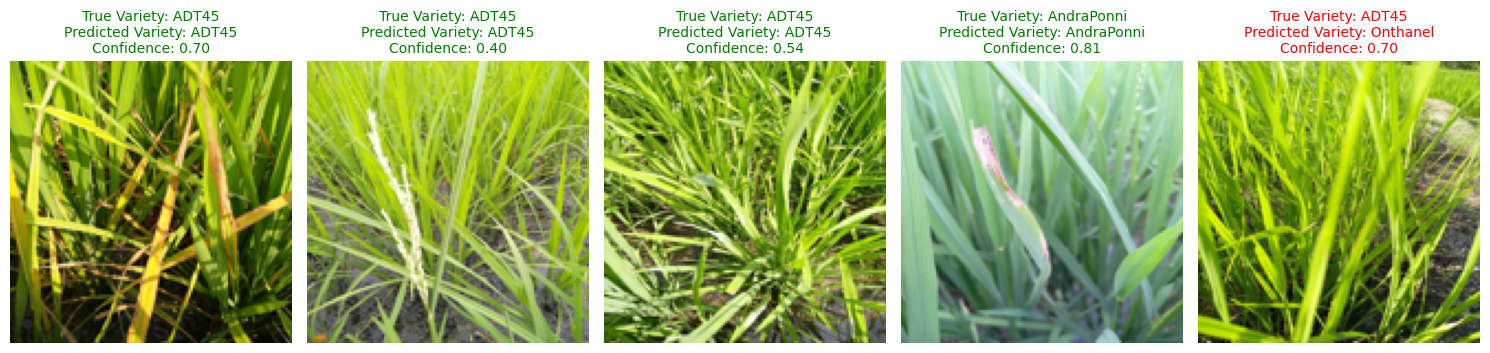

Correctly predicted 4 out of 5 images (80.0%)


In [285]:
# From your TRAIN generator
class_indices = task2_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}
class_names = [inv_class_indices[i] for i in range(len(inv_class_indices))]
# Call the function
mt.predict_and_show_samples(
    model=efficientnet_adv_model,
    df=val_df,
    class_names=class_names,
    num_samples=5,
    rows=1,
    cols=5,
    random_select=True,
    label_col="variety",           # Use 'label' if it's for Task 1
    prediction_type="Variety"
)